In [19]:
import sys
import os
import sys
import pwd
import glob as glob

# analysis
import pandas as pd
import numpy as np
import math

# helper
from datetime import date
import subprocess

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 

%matplotlib inline 
import altair as alt
# alt.renderers.enable('html')
import plotnine as pn

# gh specific
sys.path.append('/ghds/projects/pharma/shared_scripts/')
import bibp.functions as functions
import hgvslib.pHGVS as pHGVS  ## do a pull on the hgvslib git repo

pd.options.display.max_columns  =  1000
pd.set_option('max_colwidth', 100)
pd.options.display.max_rows=1000

alt.renderers.enable('mimetype') # https://altair-viz.github.io/user_guide/display_frontends.html#displaying-in-jupyterlab

sns.set_palette("colorblind")
sns.set_context("talk")
plt.rcParams["axes.labelweight"] = "bold"

In [2]:
# work_dir = "/ghsfa/projects/pharma/projects/sirius_pharma/ep1/early_batches_eval/"
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/EP1_batches_TB_Review/"
if not os.path.exists(work_dir):
  os.mkdir(work_dir)

os.chdir(work_dir)

In [3]:
import gspread
from google.oauth2.service_account import Credentials
import oauth2client

scopes = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]
credentials = Credentials.from_service_account_file(
    '/ghdevhome/home/mcai/gh-mcai/project/061222_MRK_SOW26/client_secret.json',
    scopes=scopes
)

gc = gspread.authorize(credentials)

In [4]:
def read_sheet(filename, sheetname="Sheet1"):
  """  """
  sh = gc.open(filename)
  worksheet = sh.worksheet("Sheet1")
  df = pd.DataFrame(worksheet.get_all_records(head=4))
  return df

In [20]:
def plot_patient_journey(batch_dat, out_prefix):
  """ show ctDNA detection status across time points in a swimmer plot """
  df = batch_dat.copy()
  sample_level_report_df = df[["GHRequestID", "GHSampleID", "Patient_ID", "Visit_name", "Sample_status", 
                               "Tumor_methylation_status", "Tumor_methylation_score", "Bloodcoll_date"]].drop_duplicates()
  sample_level_report_df["Bloodcoll_date"] = pd.to_datetime(sample_level_report_df["Bloodcoll_date"])
  sample_level_report_df["Patient_ID"] = sample_level_report_df["Patient_ID"].astype(str)
  sample_level_report_df.loc[sample_level_report_df["Sample_status"] != "SUCCESS", "Tumor_methylation_status"] = "FAIL"
  
  baseline_timepoint_df = sample_level_report_df.groupby(["Patient_ID"])["Bloodcoll_date"].min().to_frame().reset_index()
  sample_level_report_df = sample_level_report_df.merge(baseline_timepoint_df, on=["Patient_ID"], how="left", suffixes = ("_curr", "_baseline"))
  sample_level_report_df["interval"] = (sample_level_report_df["Bloodcoll_date_curr"] - sample_level_report_df["Bloodcoll_date_baseline"]).dt.days
  sample_level_report_df = sample_level_report_df.query('interval == interval')
  sample_level_report_df = sample_level_report_df.sort_values(by=["Patient_ID"])
  
  if len(sample_level_report_df) == 0:
    return None
  
  plt.clf()
  ax = sns.scatterplot(data = sample_level_report_df, y = "Patient_ID", x = "interval", 
                       hue = "Tumor_methylation_status", 
                       palette = {"Detected": "red",
                                 "Not Detected": "green",
                                 "FAIL": sns.dark_palette("xkcd:golden")[0],
                                 "NA": sns.color_palette("colorblind")[7]},
                       style = "Visit_name",
                       s=200
                  )
  ax.grid(axis='y', color="grey", alpha=0.2, lw=20)
  ax.set_axisbelow(True)
  plt.xlabel("Days")
  plt.margins(y=1/df["Patient_ID"].nunique())
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1, fontsize="medium", title="")

  figure = plt.gcf()
  figure.set_size_inches(9, max(6, (df["Patient_ID"].nunique())/2+1))
  plt.savefig(f"{out_prefix}_patient_journey.png", bbox_inches="tight", dpi=300, facecolor="white", transparent=False)

## COS_IST03_Reveal_03 (GC)

In [44]:
cos_03_03_df = pd.read_csv(f"{work_dir}/UHP01_IST01_Reveal_02_Run_32177_BART_v0 - Sheet1.csv", header = 3)
cos_03_03_df.shape

(252, 22)

In [45]:
cos_03_03_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,NaN,B00889936,RES-67,12 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247490,250109_LH00520_0078_A22W5THLT3,NaN,NaN,3.242751e-06,LUNG,-3.033694,-1.040062,-1.273142,-1.361467,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889936.oncotrack.pdf
1,2,NaN,B00889937,RES-25,20 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247292,250109_LH00520_0078_A22W5THLT3,NaN,NaN,1.427399e-07,LUNG,-2.690132,-1.394885,-1.680266,-1.709769,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889937.oncotrack.pdf
2,3,NaN,B00889938,RES-63,6 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247491,250109_LH00520_0078_A22W5THLT3,NaN,NaN,1.263981e-04,LUNG,-3.727183,-1.621821,-2.251184,-1.585451,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889938.oncotrack.pdf
3,4,NaN,B00889939,RES-25,30 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247291,250109_LH00520_0078_A22W5THLT3,NaN,NaN,1.320191e-05,LUNG,-2.840563,-1.449328,-1.657267,-1.249221,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889939.oncotrack.pdf
4,5,NaN,B00889940,RES-59,Pre-Surgery,Non-small cell lung carcinoma (NSCLC),A1247531,250109_LH00520_0078_A22W5THLT3,NaN,NaN,6.483526e-06,LUNG,-2.549241,-0.927470,-1.330356,-1.143371,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889940.oncotrack.pdf


In [46]:
cos_03_03_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3',
       '/ghds/ivd/flowcentral/250111_LH00520_0081_A22W5NCLT3',
       '/ghds/ivd/flowcentral/250116_LH00505_0089_B22WHJCLT3'],
      dtype=object)

In [47]:
from tqdm import tqdm

In [48]:
from plotnine import *

In [49]:
# Define a color mapping based on status
color_map = {
    "FAIL": "red",    # red for FAIL
    "PASS": "green",  # green for PASS
    "REVIEW": "orange" # orange for REVIEW
}


In [50]:
# for _, row in tqdm(cos_03_df.iterrows(), total=cos_03_df.shape[0], desc="Processing Rows"):

def get_qc(bart_df):
  quto_qc_df_all_lst = []

  for bip_dir in bart_df["data_dir"].unique():
    auto_qc_tsv = f"{bip_dir}/autoqc_sample_qc.hdr.tsv"
    quto_qc_df = pd.read_csv(auto_qc_tsv, sep="\t")
    quto_qc_df_all_lst.append(quto_qc_df)

  quto_qc_df_all = pd.concat(quto_qc_df_all_lst, axis=0)
  
  samp_lst = set(bart_df["run_sample_id"].unique())
  quto_qc_df_all = quto_qc_df_all.query('run_sample_id.notna() & run_sample_id in @samp_lst').copy()
  
  return quto_qc_df_all

In [51]:
cos_03_03_qc_df = get_qc(cos_03_03_df)

In [52]:
cos_03_03_qc_df.shape

(2952, 14)

In [53]:
cos_03_03_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
0,250109_LH00520_0078_A22W5THLT3,NRE20241001R0085,B00890020,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.0,<=,25.0000,PASS,0
1,250109_LH00520_0078_A22W5THLT3,NRE20241001R0085,B00889953,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,10.0,==,11.0000,REVIEW,0
2,250109_LH00520_0078_A22W5THLT3,NRE20241001R0085,B00890001,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,2.0,<=,20.0000,PASS,0
3,250109_LH00520_0078_A22W5THLT3,NRE20241001R0085,B00889996,sample,EpiReveal-1.0.0-RLS,DNA,median_molecule_length,Median Molecule Length,bases,170.0,<=,218.0000,PASS,0
4,250109_LH00520_0078_A22W5THLT3,NRE20241001R0085,B00889956,sample,EpiReveal-1.0.0-RLS,DNA,methyl_neg_capture,Methyl Neg capture (Hyper-partition:methyl-subpanel),NaN,0.0,<=,0.0093,PASS,5


In [54]:
def plot_qc_heatmap(qc_df, out_prefix = "out", width=14, height=5):
  heatmap = (ggplot(qc_df, aes(y='metric', x='run_sample_id', fill='status'))
             + geom_tile(color="white")  # Create the tiles of the heatmap
             + scale_fill_manual(values=color_map)  # Apply the color mapping
             + theme_bw()  # Clean background
             + theme(axis_text_x=element_text(rotation=90, hjust=0.5), 
                     figure_size=(width, height) )  # Rotate x-axis labels for readability
             # + labs(title="Sample Quality Control Status Heatmap", 
             #           y="Metric", x="Sample ID", fill="Status")  # Labels and title
  )

  # Display the plot
  print(heatmap)
  ggsave(heatmap, out_prefix)

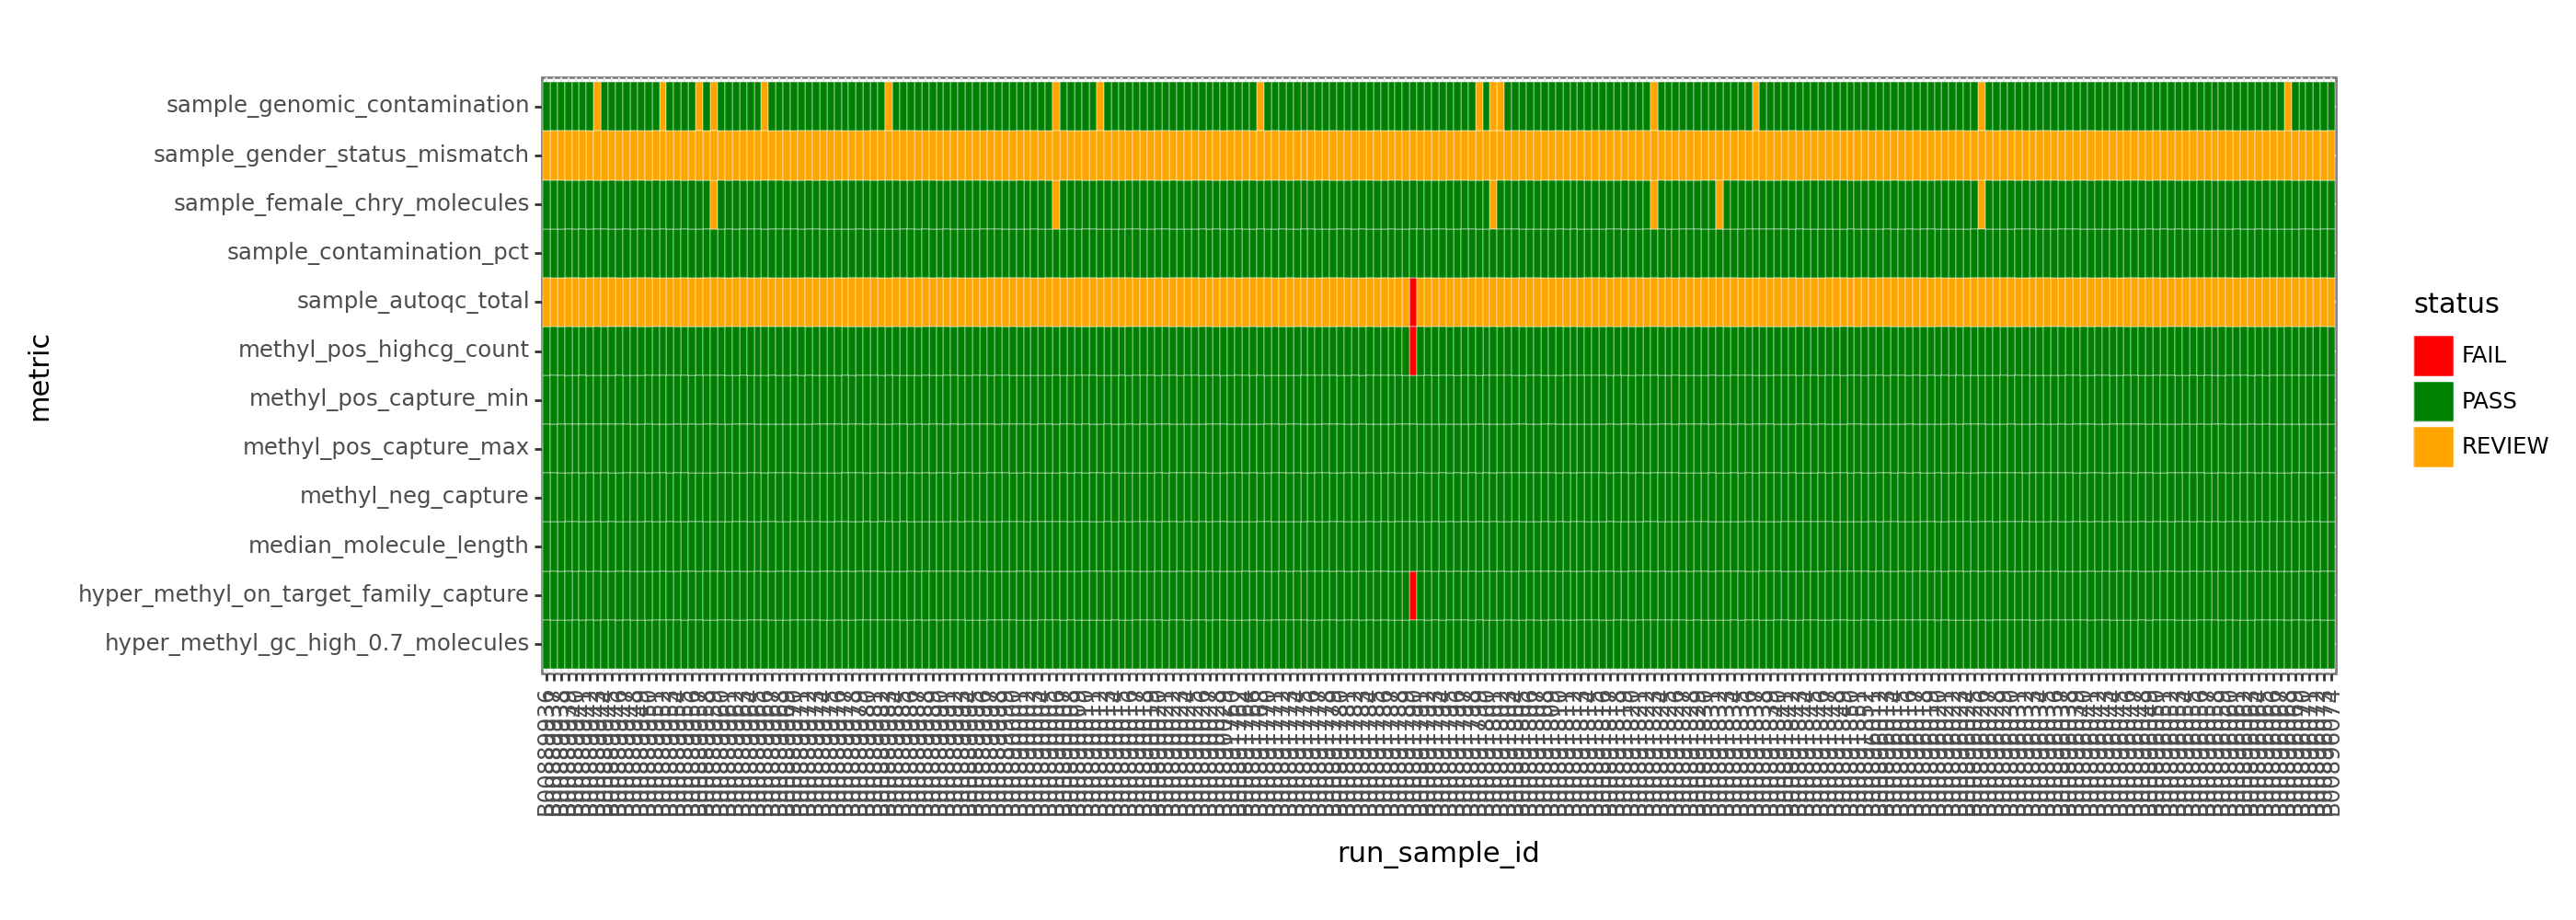

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 14 x 5 in image.
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: COS_IST03_Reveal_03_auto_qc_2025-02-07


In [55]:
plot_qc_heatmap(cos_03_03_qc_df, out_prefix = "COS_IST03_Reveal_03_auto_qc_{}".format(date.today()), width=14, height=5)

In [56]:
cos_03_03_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,NaN,B00889936,RES-67,12 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247490,250109_LH00520_0078_A22W5THLT3,NaN,NaN,3.242751e-06,LUNG,-3.033694,-1.040062,-1.273142,-1.361467,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889936.oncotrack.pdf
1,2,NaN,B00889937,RES-25,20 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247292,250109_LH00520_0078_A22W5THLT3,NaN,NaN,1.427399e-07,LUNG,-2.690132,-1.394885,-1.680266,-1.709769,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889937.oncotrack.pdf
2,3,NaN,B00889938,RES-63,6 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247491,250109_LH00520_0078_A22W5THLT3,NaN,NaN,1.263981e-04,LUNG,-3.727183,-1.621821,-2.251184,-1.585451,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889938.oncotrack.pdf
3,4,NaN,B00889939,RES-25,30 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247291,250109_LH00520_0078_A22W5THLT3,NaN,NaN,1.320191e-05,LUNG,-2.840563,-1.449328,-1.657267,-1.249221,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889939.oncotrack.pdf
4,5,NaN,B00889940,RES-59,Pre-Surgery,Non-small cell lung carcinoma (NSCLC),A1247531,250109_LH00520_0078_A22W5THLT3,NaN,NaN,6.483526e-06,LUNG,-2.549241,-0.927470,-1.330356,-1.143371,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889940.oncotrack.pdf


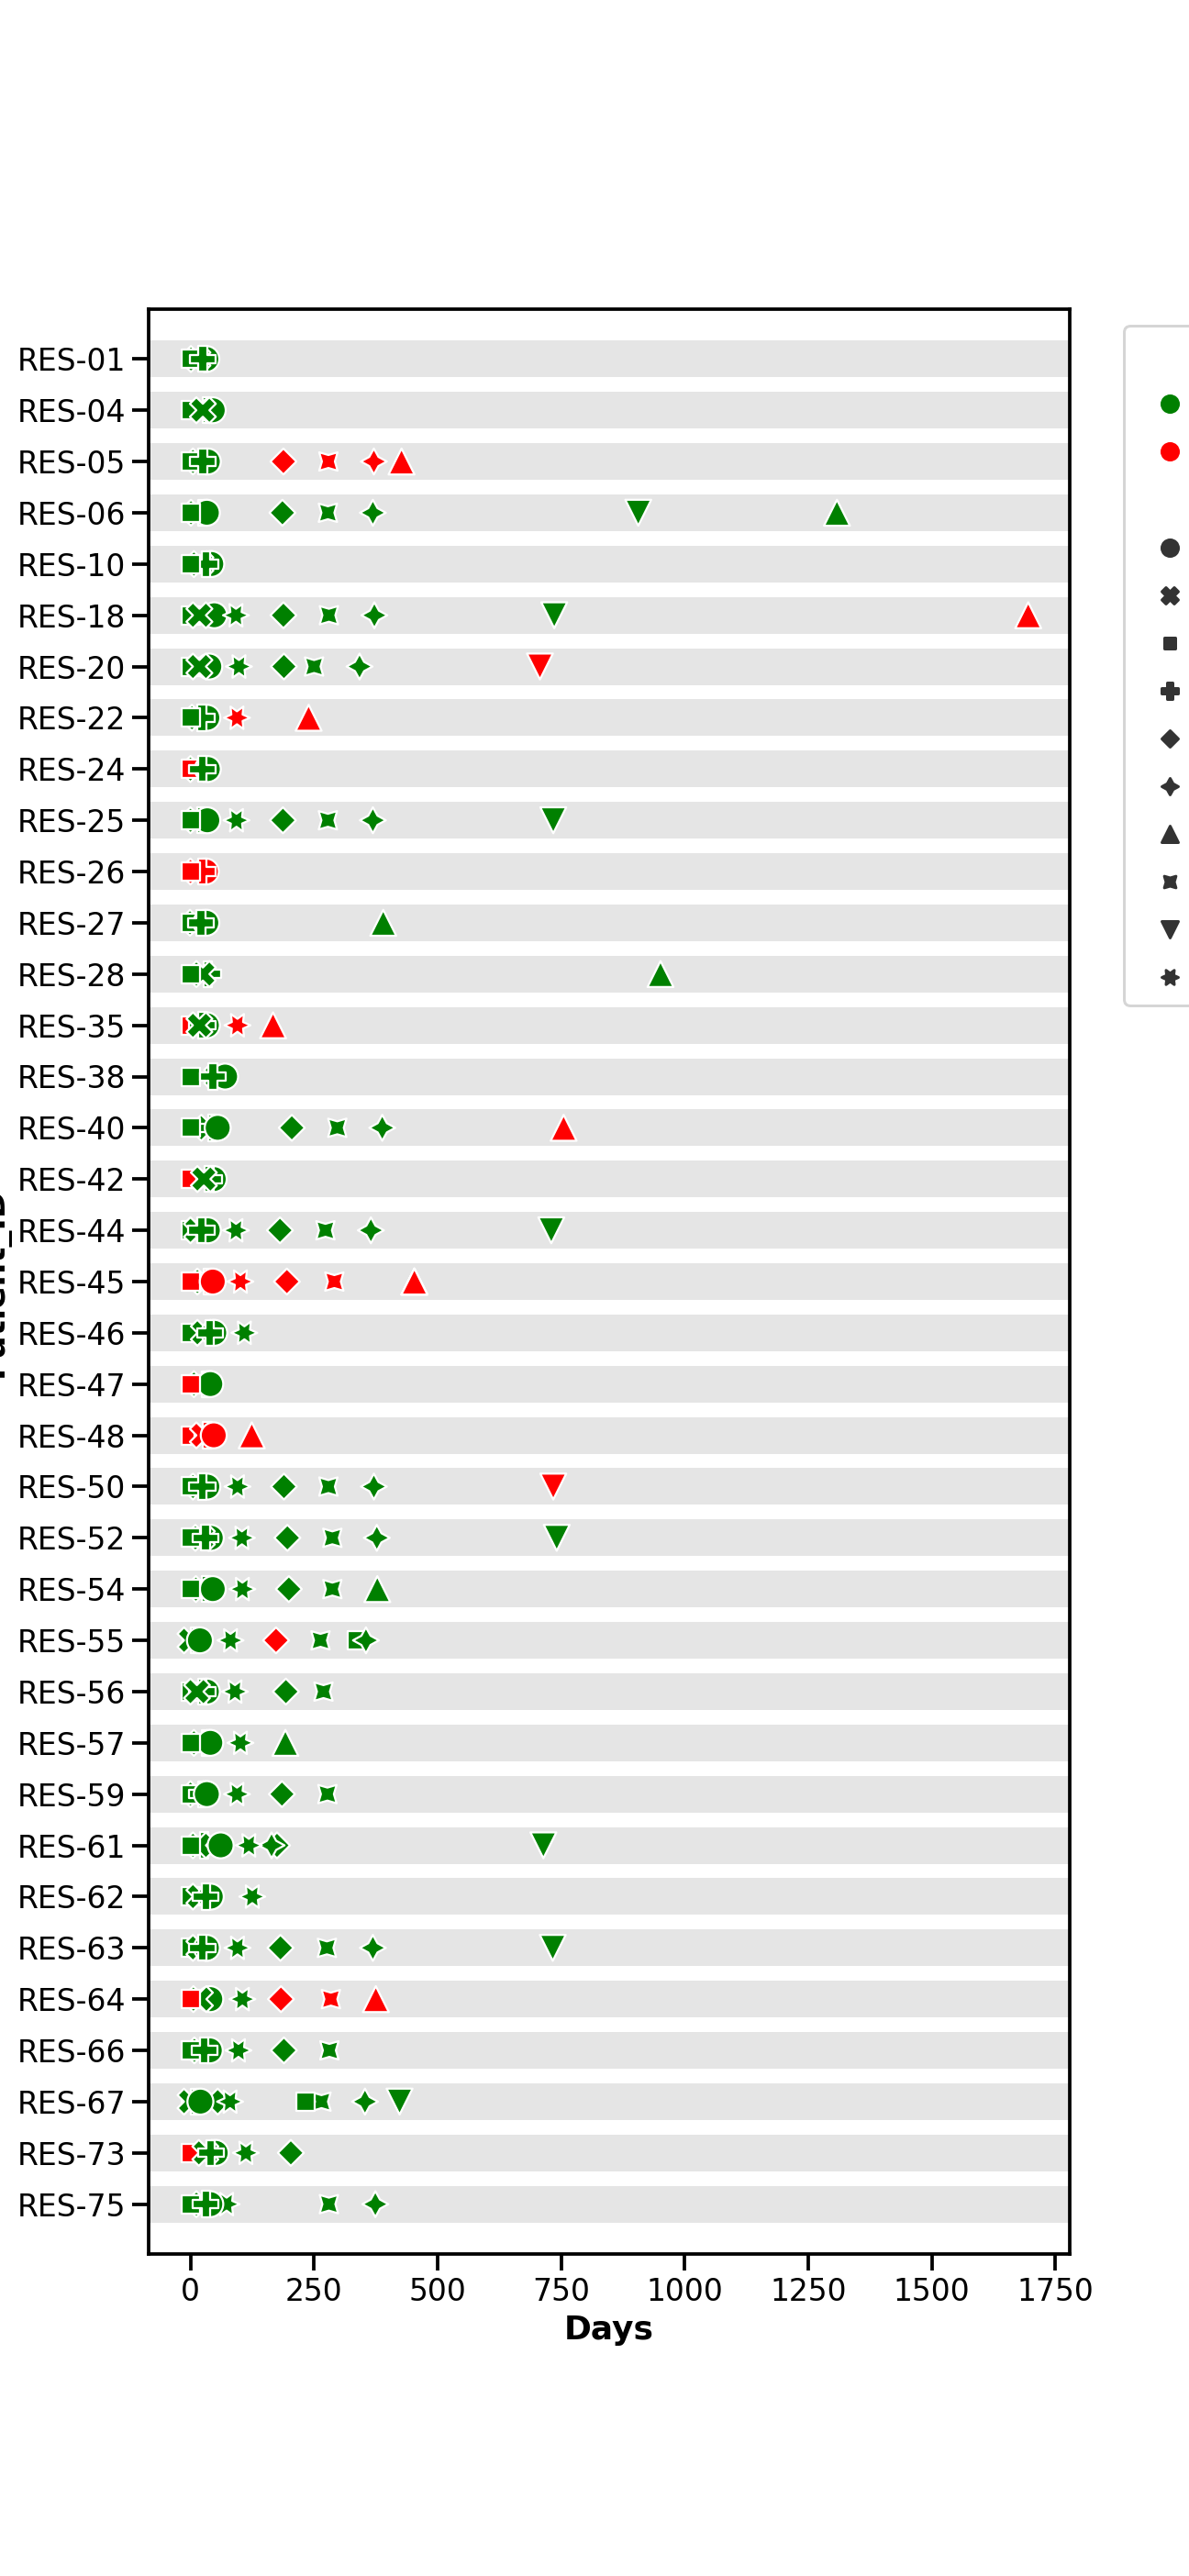

In [57]:
cos_03_report_df = pd.read_csv(f"{work_dir}/20250121_GuardantHealthIST_IST01_Batch2_246Samples_MonitoringReport.csv", header = 1)

plot_patient_journey(cos_03_report_df, out_prefix = "COS_IST03_Reveal_03_auto_qc_{}.format(date.today())")

In [ ]:
samp_review_lst = cos_03_03_qc_df.query('status != "PASS"')["run_sample_id"].unique()
cos_03_03_qc_df.query('run_sample_id in @samp_review_lst & metric in ["sample_contamination_pct", "sample_female_chry_molecules", "sample_genomic_contamination"]').sort_values(by=["run_sample_id", "metric"])

In [ ]:
cos_03_03_df.query('run_sample_id in @samp_review_lst')

In [ ]:
cos_03_03_df.query('run_sample_id in @samp_review_lst')[["run_sample_id", "Patient_ID", "Visit_name", "methyl_score_PANCANCER", "methyl_score_BREAST", "methyl_score_CRC", "methyl_score_LUNG"]]

,run_sample_id,Patient_ID,Visit_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG


In [81]:
def calc_pos_rate(ruo_report_df):
  """  """
  tot_cnt = ruo_report_df.groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
  pos_cnt = ruo_report_df.query('Tumor_methylation_status == "Detected"').groupby(["Visit_name"])["Tumor_methylation_status"].count().reset_index()
  pos_tot_cnt = tot_cnt.merge(pos_cnt, on=["Visit_name"], how="outer").fillna(0).rename(columns={
    "Tumor_methylation_status_x": "Total",
    "Tumor_methylation_status_y": "Positive"
  })

  sum_row = pos_tot_cnt.sum(axis=0).to_frame().T
  sum_row.loc[0, "Visit_name"] = "Total"

  pos_tot_cnt_sum = pd.concat([pos_tot_cnt, sum_row], axis=0)
  pos_tot_cnt_sum["Positive_percentage"] = (100*pos_tot_cnt_sum["Positive"].astype(int)/pos_tot_cnt_sum["Total"].astype(int)).round(1)
  return pos_tot_cnt_sum

In [ ]:
cos_03_03_ruo_report_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20250115_NationalCancerCenterEast_IST03_Batch3_18Samples_MonitoringReport.csv",
                                     skiprows=1)

In [ ]:
calc_pos_rate(cos_03_03_ruo_report_df)

,Visit_name,Total,Positive,Positive_percentage
0,1 Year,1,0.0,0.0
1,1 Year and 6 Months,1,1.0,100.0
2,2 Years,1,0.0,0.0
3,28 Days,4,4.0,100.0
4,3 Months,1,0.0,0.0
5,9 Months,2,0.0,0.0
6,Pre-NAC,1,1.0,100.0
7,Pre-Surgery,7,6.0,85.7
0,Total,18,12.0,66.7


In [ ]:
cos_03_03_ruo_report_df.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,NaN,NaN,A0304644,A030464409,COS-GC0008,NaN,NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.005347,NaN,4.0,NaN,11/16/2020,11/12/2020,01/15/2025
1,NaN,NaN,A0311130,A031113009,COS-GC0008,NaN,NaN,28 Days,SUCCESS,NaN,Detected,Detected,0.015986,NaN,4.0,NaN,12/08/2020,12/07/2020,01/15/2025
2,NaN,NaN,A0312797,A031279709,COS-GC0027,NaN,NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.001100,NaN,4.0,NaN,12/14/2020,12/11/2020,01/15/2025
3,NaN,NaN,A0346475,A034647509,COS-GC0183,NaN,NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.000371,NaN,4.0,NaN,04/13/2021,04/12/2021,01/15/2025
4,NaN,NaN,A0355393,A035539309,COS-GC0137,NaN,NaN,3 Months,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,4.0,NaN,05/13/2021,05/11/2021,01/15/2025


## UHP01_IST01_Reveal_02 (lung) [Most comprehensive examples]

In [60]:
UHP01_IST01_Reveal_02_df = pd.read_csv(f"{work_dir}/UHP01_IST01_Reveal_02_Run_32177_BART_v0 - Sheet1.csv", header = 3)
UHP01_IST01_Reveal_02_df.shape

(252, 22)

In [61]:
UHP01_IST01_Reveal_02_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,NaN,B00889936,RES-67,12 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247490,250109_LH00520_0078_A22W5THLT3,NaN,NaN,3.242751e-06,LUNG,-3.033694,-1.040062,-1.273142,-1.361467,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889936.oncotrack.pdf
1,2,NaN,B00889937,RES-25,20 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247292,250109_LH00520_0078_A22W5THLT3,NaN,NaN,1.427399e-07,LUNG,-2.690132,-1.394885,-1.680266,-1.709769,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889937.oncotrack.pdf
2,3,NaN,B00889938,RES-63,6 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247491,250109_LH00520_0078_A22W5THLT3,NaN,NaN,1.263981e-04,LUNG,-3.727183,-1.621821,-2.251184,-1.585451,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889938.oncotrack.pdf
3,4,NaN,B00889939,RES-25,30 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247291,250109_LH00520_0078_A22W5THLT3,NaN,NaN,1.320191e-05,LUNG,-2.840563,-1.449328,-1.657267,-1.249221,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889939.oncotrack.pdf
4,5,NaN,B00889940,RES-59,Pre-Surgery,Non-small cell lung carcinoma (NSCLC),A1247531,250109_LH00520_0078_A22W5THLT3,NaN,NaN,6.483526e-06,LUNG,-2.549241,-0.927470,-1.330356,-1.143371,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889940.oncotrack.pdf


In [62]:
UHP01_IST01_Reveal_02_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3',
       '/ghds/ivd/flowcentral/250111_LH00520_0081_A22W5NCLT3',
       '/ghds/ivd/flowcentral/250116_LH00505_0089_B22WHJCLT3'],
      dtype=object)

In [63]:
UHP01_IST01_Reveal_02_qc_df = get_qc(UHP01_IST01_Reveal_02_df)

In [64]:
UHP01_IST01_Reveal_02_qc_df.shape

(2952, 14)

In [65]:
UHP01_IST01_Reveal_02_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
0,250109_LH00520_0078_A22W5THLT3,NRE20241001R0085,B00890020,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.0,<=,25.0000,PASS,0
1,250109_LH00520_0078_A22W5THLT3,NRE20241001R0085,B00889953,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,10.0,==,11.0000,REVIEW,0
2,250109_LH00520_0078_A22W5THLT3,NRE20241001R0085,B00890001,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,2.0,<=,20.0000,PASS,0
3,250109_LH00520_0078_A22W5THLT3,NRE20241001R0085,B00889996,sample,EpiReveal-1.0.0-RLS,DNA,median_molecule_length,Median Molecule Length,bases,170.0,<=,218.0000,PASS,0
4,250109_LH00520_0078_A22W5THLT3,NRE20241001R0085,B00889956,sample,EpiReveal-1.0.0-RLS,DNA,methyl_neg_capture,Methyl Neg capture (Hyper-partition:methyl-subpanel),NaN,0.0,<=,0.0093,PASS,5


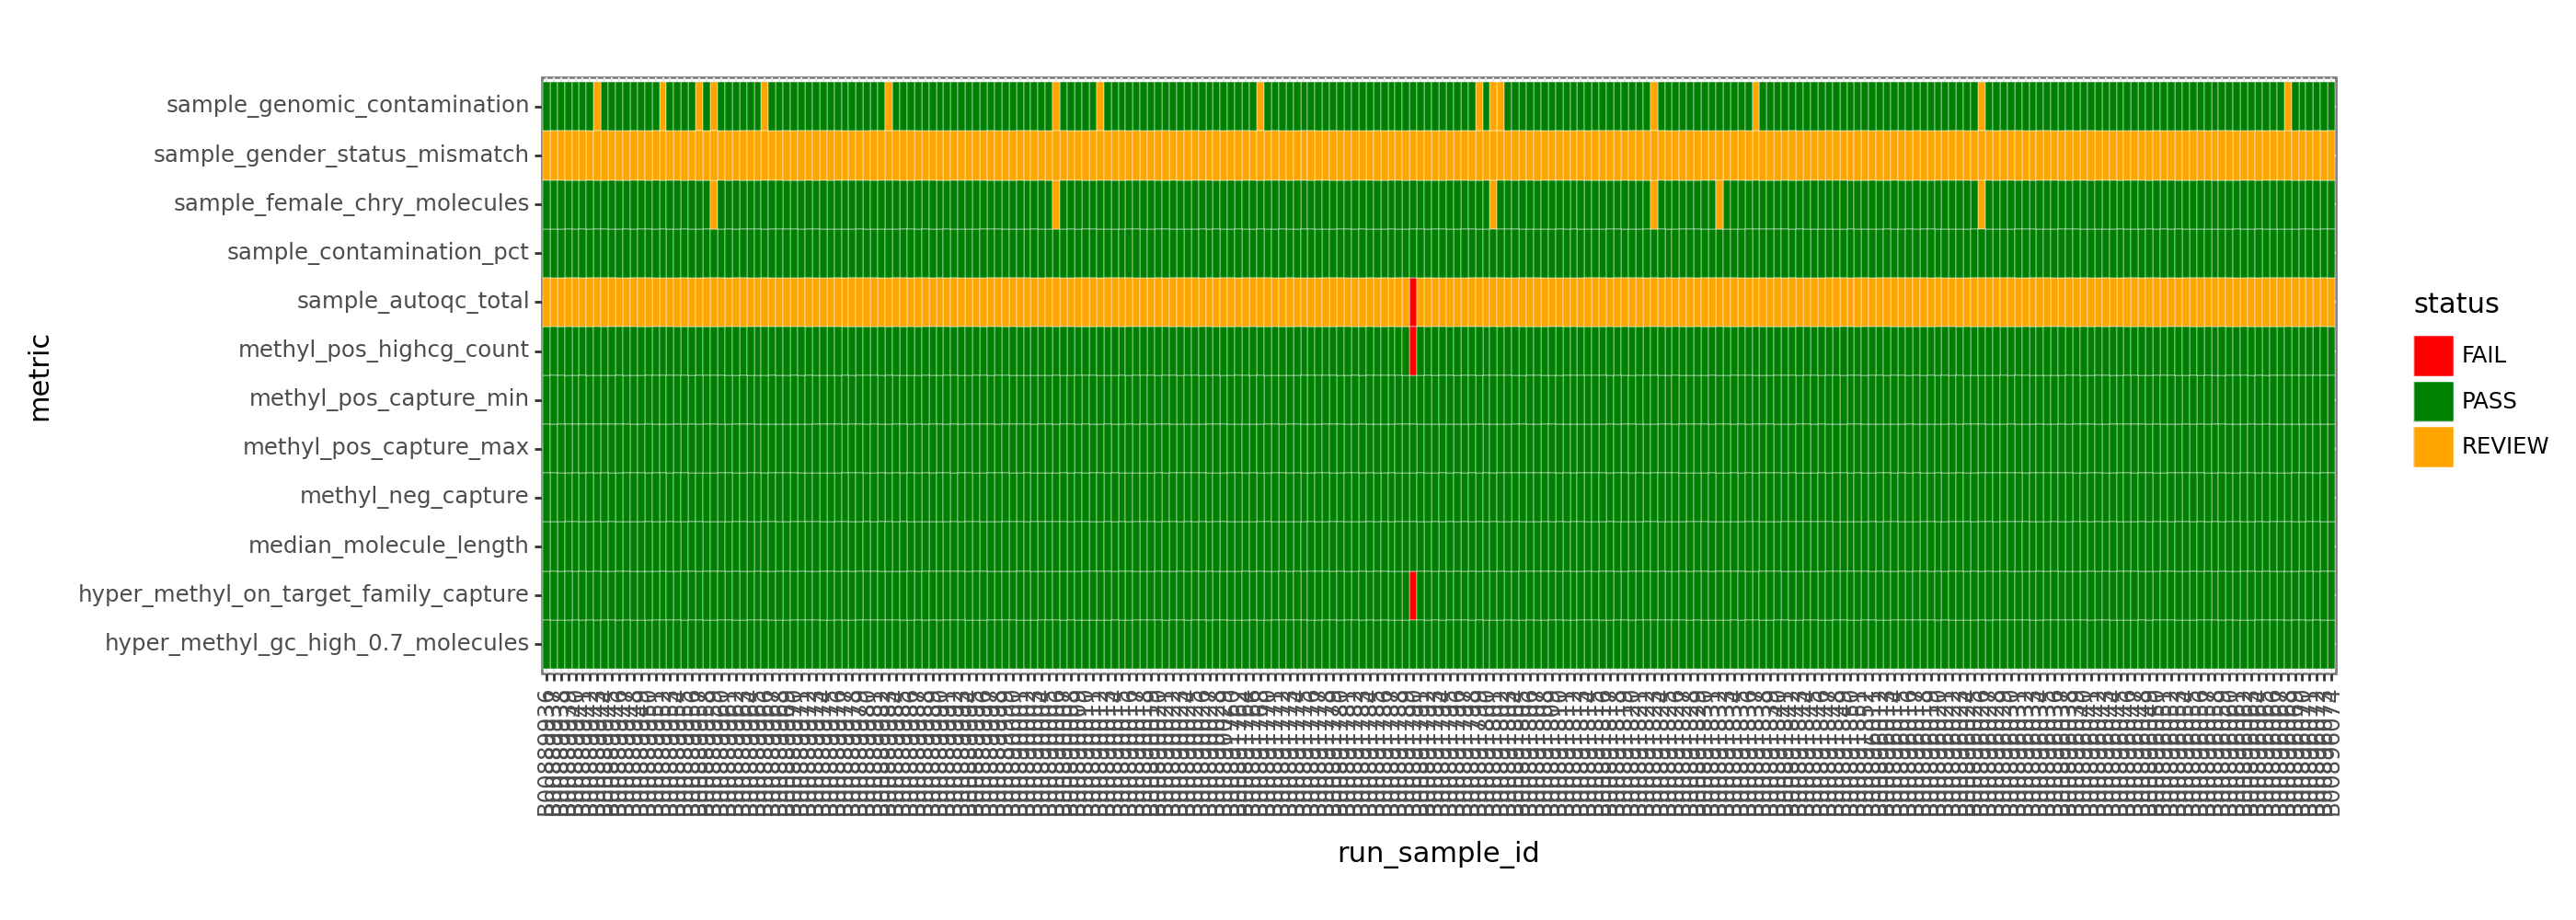

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 14 x 5 in image.
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: UHP01_IST01_Reveal_02_auto_qc_2025-02-07


In [66]:
plot_qc_heatmap(UHP01_IST01_Reveal_02_qc_df, out_prefix = "UHP01_IST01_Reveal_02_auto_qc_{}".format(date.today()), width=14, height=5)

In [67]:
UHP01_IST01_Reveal_02_qc_df.query('status == "FAIL"')

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
15,250111_LH00520_0081_A22W5NCLT3,NRE20241001R0099,B00891790,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,8.000,==,11.0,FAIL,0
281,250111_LH00520_0081_A22W5NCLT3,NRE20241001R0099,B00891790,sample,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_on_target_family_capture,On-target family capture (Hyper-partition:methyl-subpanel),NaN,0.678,>=,2.8,FAIL,3
324,250111_LH00520_0081_A22W5NCLT3,NRE20241001R0099,B00891790,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,8160.000,>=,13500.0,FAIL,0


In [ ]:
samp_review_lst = UHP01_IST01_Reveal_02_qc_df.query('status != "PASS" & metric not in ["sample_autoqc_total", "sample_gender_status_mismatch"]')["run_sample_id"].unique()
UHP01_IST01_Reveal_02_qc_df.query('run_sample_id in @samp_review_lst & metric in ["sample_contamination_pct", "sample_female_chry_molecules", "sample_genomic_contamination"]').sort_values(by=["run_sample_id", "metric"])

In [ ]:
UHP01_IST01_Reveal_02_df.query('run_sample_id in @samp_review_lst')[["run_sample_id", "Patient_ID", "Visit_name", "methyl_score_PANCANCER", "methyl_score_BREAST", "methyl_score_CRC", "methyl_score_LUNG"]]

### contamination, positive

In [69]:
UHP01_IST01_Reveal_02_df["flags"].unique()

array([nan, 'Genomic contamination', 'Female chrY contamination',
       'Methyl Input (Hyper-partition:methyl-subpanel)',
       'On-target family capture (Hyper-partition:methyl-subpanel)'],
      dtype=object)

In [70]:
contam_review_df = UHP01_IST01_Reveal_02_df.query('flags in ["Genomic contamination", "Female chrY contamination"] & \
  methyl_score_LUNG >= 0').copy()
contam_review_df

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
16,17,NaN,B00889952,RES-26,Pre-Surgery,Non-small cell lung carcinoma (NSCLC),A1247416,250109_LH00520_0078_A22W5THLT3,sample_qc,Sample_level,0.000480,LUNG,2.187510,1.403787,1.493568,6.843989,Genomic contamination,REVIEW sample_genomic_contamination 72.0 <= 20.0 markers,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889952.oncotrack.pdf
23,24,NaN,B00889959,RES-64,6 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247540,250109_LH00520_0078_A22W5THLT3,sample_qc,Sample_level,0.000939,LUNG,1.394689,1.043253,0.587068,9.093393,Genomic contamination,REVIEW sample_genomic_contamination 68.0 <= 20.0 markers,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889959.oncotrack.pdf
24,25,NaN,B00889959,RES-64,6 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247540,250109_LH00520_0078_A22W5THLT3,sample_qc,Sample_level,0.000939,LUNG,1.394689,1.043253,0.587068,9.093393,Female chrY contamination,REVIEW sample_female_chry_molecules 168.0 <= 25.0 molecules,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889959.oncotrack.pdf


In [ ]:
# 3 samples with contam flag and positive methyl status (intent to add warning anyway regardless of longitudinal results)
# check the methyl status longitudinally

In [71]:
UHP01_IST01_Reveal_02_df.query('Patient_ID == "RES-26"')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
6,7,NaN,B00889942,RES-26,20 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247411,250109_LH00520_0078_A22W5THLT3,NaN,NaN,0.000856,LUNG,2.035879,1.556227,1.295882,6.557196,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889942.oncotrack.pdf
16,17,NaN,B00889952,RES-26,Pre-Surgery,Non-small cell lung carcinoma (NSCLC),A1247416,250109_LH00520_0078_A22W5THLT3,sample_qc,Sample_level,0.000480,LUNG,2.187510,1.403787,1.493568,6.843989,Genomic contamination,REVIEW sample_genomic_contamination 72.0 <= 20.0 markers,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889952.oncotrack.pdf
123,124,NaN,B00891791,RES-26,10 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247412,250111_LH00520_0081_A22W5NCLT3,NaN,NaN,0.000076,LUNG,-1.671773,-0.643382,-0.899711,0.979903,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250111_LH00520_0081_A22W5NCLT3,B00891791.oncotrack.pdf
125,126,NaN,B00891793,RES-26,30 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247413,250111_LH00520_0081_A22W5NCLT3,NaN,NaN,0.000560,LUNG,1.913068,1.334499,0.569795,6.051772,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250111_LH00520_0081_A22W5NCLT3,B00891793.oncotrack.pdf


In [72]:
UHP01_IST01_Reveal_02_df.query('Patient_ID == "RES-26" & methyl_score_LUNG >= 0')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
6,7,NaN,B00889942,RES-26,20 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247411,250109_LH00520_0078_A22W5THLT3,NaN,NaN,0.000856,LUNG,2.035879,1.556227,1.295882,6.557196,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889942.oncotrack.pdf
16,17,NaN,B00889952,RES-26,Pre-Surgery,Non-small cell lung carcinoma (NSCLC),A1247416,250109_LH00520_0078_A22W5THLT3,sample_qc,Sample_level,0.000480,LUNG,2.187510,1.403787,1.493568,6.843989,Genomic contamination,REVIEW sample_genomic_contamination 72.0 <= 20.0 markers,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889952.oncotrack.pdf
123,124,NaN,B00891791,RES-26,10 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247412,250111_LH00520_0081_A22W5NCLT3,NaN,NaN,0.000076,LUNG,-1.671773,-0.643382,-0.899711,0.979903,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250111_LH00520_0081_A22W5NCLT3,B00891791.oncotrack.pdf
125,126,NaN,B00891793,RES-26,30 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247413,250111_LH00520_0081_A22W5NCLT3,NaN,NaN,0.000560,LUNG,1.913068,1.334499,0.569795,6.051772,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250111_LH00520_0081_A22W5NCLT3,B00891793.oncotrack.pdf


In [73]:
# DECISION: Pass this sample with warning. Actually all the longitudinal samples are positive, it's very likely this is a positive case as well. But to be safe, I added a warning.

In [ ]:
# DECISION: keep this sample success, and add possible contam warning

### Methyl Pos capture min (Hyper-partition:methyl-subpanel)

In [ ]:
methyl_pos_capture_min_review_df = inv01epi_01_01_df.query('flags == "Methyl Pos capture min (Hyper-partition:methyl-subpanel)"').copy()

In [ ]:
methyl_pos_capture_min_review_df

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf


In [ ]:
inv01epi_01_01_df.query('Patient_ID == 168 | Patient_ID == "168"')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
15,16,,B00875627,168,8 WEEKS,Head and neck squamous cell carcinoma,A1220211,241221_LH00520_0066_B22W57KLT3,,,0.00003,PANCANCER,-2.148528,-1.175015,-1.308029,-1.781155,,,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875627.oncotrack.pdf
195,196,,B00881051,168,FU 3 MONTHS,Head and neck squamous cell carcinoma,A1220153,241225_LH00505_0079_A22W57CLT3,methyl_qc,Sample_level,0.00002,PANCANCER,-2.170420,-0.958177,-1.164310,-1.250827,,REVIEW hyper_methyl_pos_capture 1.03575690244003,,no change,/ghds/ivd/flowcentral/241225_LH00505_0079_A22W57CLT3,B00881051.oncotrack.pdf
196,197,,B00881051,168,FU 3 MONTHS,Head and neck squamous cell carcinoma,A1220153,241225_LH00505_0079_A22W57CLT3,sample_qc,Sample_level,0.00002,PANCANCER,-2.170420,-0.958177,-1.164310,-1.250827,Methyl Pos capture min (Hyper-partition:methyl-subpanel),FAIL methyl_pos_capture_min 1.03576 >= 1.1,,,/ghds/ivd/flowcentral/241225_LH00505_0079_A22W57CLT3,B00881051.oncotrack.pdf
420,421,,B00888856,168,12 WEEKS,Head and neck squamous cell carcinoma,A1220020,250108_LH00520_0075_A22W55KLT3,,,0.00004,PANCANCER,-2.557442,-1.096500,-1.634516,-0.991258,,,,,/ghds/ivd/flowcentral/250108_LH00520_0075_A22W55KLT3,B00888856.oncotrack.pdf


In [ ]:
## DECISION: add a "Methylation Suppression Warning" for the above sample (given all 3 time points were negative, seems okay)

### Methyl Input (Hyper-partition:methyl-subpanel)

In [76]:
methyl_input_review_df = UHP01_IST01_Reveal_02_df.query('flags == "Methyl Input (Hyper-partition:methyl-subpanel)"').copy()

In [77]:
methyl_input_review_df

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
121,122,NaN,B00891790,RES-59,20 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247533,250111_LH00520_0081_A22W5NCLT3,sample_qc,Sample_level,0.00119,LUNG,-1.930569,-1.326604,-0.845038,-0.90319,Methyl Input (Hyper-partition:methyl-subpanel),FAIL methyl_pos_highcg_count 8160.0 >= 13500.0 molecules,NaN,NaN,/ghds/ivd/flowcentral/250111_LH00520_0081_A22W5NCLT3,B00891790.oncotrack.pdf


In [78]:
UHP01_IST01_Reveal_02_df.query('Patient_ID == "RES-59"')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
4,5,NaN,B00889940,RES-59,Pre-Surgery,Non-small cell lung carcinoma (NSCLC),A1247531,250109_LH00520_0078_A22W5THLT3,NaN,NaN,0.000006,LUNG,-2.549241,-0.927470,-1.330356,-1.143371,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889940.oncotrack.pdf
19,20,NaN,B00889955,RES-59,10 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247534,250109_LH00520_0078_A22W5THLT3,NaN,NaN,0.000648,LUNG,-2.777091,-0.901504,-1.600463,-0.237171,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00889955.oncotrack.pdf
89,90,NaN,B00890023,RES-59,6 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247524,250109_LH00520_0078_A22W5THLT3,NaN,NaN,0.002543,LUNG,-2.135399,-0.920941,-0.800741,-0.852669,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00890023.oncotrack.pdf
94,95,NaN,B00890028,RES-59,9 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247523,250109_LH00520_0078_A22W5THLT3,NaN,NaN,0.000005,LUNG,-2.871280,-1.469676,-1.224543,-1.374312,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250109_LH00520_0078_A22W5THLT3,B00890028.oncotrack.pdf
118,119,NaN,B00891787,RES-59,30 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247536,250111_LH00520_0081_A22W5NCLT3,NaN,NaN,0.000210,LUNG,-2.327748,-0.975250,-1.433979,-1.124754,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250111_LH00520_0081_A22W5NCLT3,B00891787.oncotrack.pdf
121,122,NaN,B00891790,RES-59,20 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247533,250111_LH00520_0081_A22W5NCLT3,sample_qc,Sample_level,0.001190,LUNG,-1.930569,-1.326604,-0.845038,-0.903190,Methyl Input (Hyper-partition:methyl-subpanel),FAIL methyl_pos_highcg_count 8160.0 >= 13500.0 molecules,NaN,NaN,/ghds/ivd/flowcentral/250111_LH00520_0081_A22W5NCLT3,B00891790.oncotrack.pdf
122,123,NaN,B00891790,RES-59,20 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1247533,250111_LH00520_0081_A22W5NCLT3,sample_qc,Sample_level,0.001190,LUNG,-1.930569,-1.326604,-0.845038,-0.903190,On-target family capture (Hyper-partition:methyl-subpanel),FAIL hyper_methyl_on_target_family_capture 0.678 >= 2.8,NaN,NaN,/ghds/ivd/flowcentral/250111_LH00520_0081_A22W5NCLT3,B00891790.oncotrack.pdf
195,196,NaN,B00896019,RES-59,3 months post-surgery,Non-small cell lung carcinoma (NSCLC),A1247535,250116_LH00505_0089_B22WHJCLT3,NaN,NaN,0.000022,LUNG,-3.096595,-1.008167,-1.303237,-1.305313,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250116_LH00505_0089_B22WHJCLT3,B00896019.oncotrack.pdf


In [79]:
## DECISION: FAIL this sample, as it has low on-target rate value.

In [89]:
# Readin report
UHP01_IST01_Reveal_02_original_df = pd.read_csv(f'{work_dir}20250131_GuardantHealthIST_IST01_Batch2_246Samples_MonitoringReport.csv', header = 1)
calc_pos_rate(UHP01_IST01_Reveal_02_original_df)

,Visit_name,Total,Positive,Positive_percentage
0,10 days post-surgery,37,2,5.4
1,12 months post-surgery,14,1,7.1
2,20 days post-surgery,33,3,9.1
3,24 months post-surgery,10,2,20.0
4,3 months post-surgery,23,3,13.0
5,30 days post-surgery,36,3,8.3
6,6 months post-surgery,20,4,20.0
7,9 months post-surgery,19,3,15.8
8,Pre-Surgery,37,9,24.3
9,Trelapse,16,11,68.8


### (Did not applied this section, asked Pooja for the post-tb instead) Change `Sample_status` and `Sample_comment`

In [ ]:
inv01epi_01_01_ruo_report_df.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,INCLIVA,79292752,A1219737,B00875612,59,Head and neck squamous cell carcinoma,IVA,12 WEEKS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,12/17/2019,01/15/2025
1,INCLIVA,79423675,A1219539,B00875613,133,Head and neck squamous cell carcinoma,III,FU 12 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,12/09/2022,01/15/2025
2,INCLIVA,79259765,A1219417,B00875614,25,Head and neck squamous cell carcinoma,IVA,BASELINE,SUCCESS,NaN,Detected,Detected,0.182863,NaN,2.0,0.0,10/30/2024,12/04/2018,01/15/2025
3,INCLIVA,79358562,A1219815,B00875615,28,Head and neck squamous cell carcinoma,III,FU 24 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,10/26/2021,01/15/2025
4,INCLIVA,79293842,A1219738,B00875616,12,Head and neck squamous cell carcinoma,III,FU 15 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,01/31/2020,01/15/2025


In [ ]:
inv01epi_01_01_ruo_report_df["Tumor_methylation_status"].value_counts(dropna=False)

Not Detected    319
Detected        119
Name: Tumor_methylation_status, dtype: int64

In [ ]:
# B00875665: FAIL, Possible Contamination
# B00881012: SUCCESS, Possible Contamination Warning
# B00881051: SUCCESS, Methylation Suppression Warning
# B00881108: SUCCESS, not to add a comment

In [ ]:
with open(ruo_report_csv, "r") as file:
    # Read all lines and take the first one
    first_line = file.readline()

In [ ]:
def line_prepender(filename, line):
  """ prepend a line to the beginning of a file """
  with open(filename, 'r+') as f:
    content = f.read()
    f.seek(0, 0)
    f.write(line.rstrip('\r\n') + '\n' + content)

In [ ]:
new_ruo_report_df = inv01epi_01_01_ruo_report_df.copy()

new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00875665", ["Sample_status"]] = "FAIL"
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00875665", ["Sample_comment"]] = "Possible Contamination"
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00875665", ["ctDNA_detected"]] = np.nan
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00875665", ["Tumor_methylation_status"]] = np.nan
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00875665", ["Tumor_methylation_score"]] = np.nan
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00881012", ["Sample_comment"]] = "Possible Contamination Warning"
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00881051", ["Sample_comment"]] = "Methylation Suppression Warning"
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00881108", ["Sample_comment"]] = "Methylation Suppression Warning"

new_ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20250120_GuardantHealth_IST01_Batch1_438Samples_MonitoringReport.csv"

new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

In [ ]:
# new new_ruo_report_df
# old inv01epi_01_01_ruo_report_df

In [ ]:
pd.concat([new_ruo_report_df, inv01epi_01_01_ruo_report_df], axis=0).drop_duplicates(keep=False).sort_values(by=["GHSampleID"])

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
53,INCLIVA,79421852,A1219833,B00875665,116,Head and neck squamous cell carcinoma,IVA,FU 18 MONTHS,FAIL,Possible Contamination,NaN,NaN,NaN,NaN,2.0,0.0,10/30/2024,09/30/2022,01/15/2025
53,INCLIVA,79421852,A1219833,B00875665,116,Head and neck squamous cell carcinoma,IVA,FU 18 MONTHS,SUCCESS,NaN,Detected,Detected,0.000174,NaN,2.0,0.0,10/30/2024,09/30/2022,01/15/2025
154,INCLIVA,79424375,A1219656,B00881012,154,Head and neck squamous cell carcinoma,IVB,8 WEEKS,SUCCESS,Possible Contamination Warning,Detected,Detected,0.000767,NaN,2.0,0.0,10/30/2024,01/20/2023,01/15/2025
154,INCLIVA,79424375,A1219656,B00881012,154,Head and neck squamous cell carcinoma,IVB,8 WEEKS,SUCCESS,NaN,Detected,Detected,0.000767,NaN,2.0,0.0,10/30/2024,01/20/2023,01/15/2025
193,INV_01,79496848,A1220153,B00881051,168,Head and neck squamous cell carcinoma,III,FU 3 MONTHS,SUCCESS,Methylation Suppression Warning,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,10/20/2023,01/15/2025
193,INV_01,79496848,A1220153,B00881051,168,Head and neck squamous cell carcinoma,III,FU 3 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,10/20/2023,01/15/2025
250,INCLIVA,BB7926,A1219451,B00881108,5,Larynx,IVA,FU 12 MONTHS,SUCCESS,Methylation Suppression Warning,Detected,Detected,0.008202,NaN,1.5,0.0,10/30/2024,11/20/2018,01/15/2025
250,INCLIVA,BB7926,A1219451,B00881108,5,Larynx,IVA,FU 12 MONTHS,SUCCESS,NaN,Detected,Detected,0.008202,NaN,1.5,0.0,10/30/2024,11/20/2018,01/15/2025


In [ ]:
new_ruo_report_df.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,INCLIVA,79292752,A1219737,B00875612,59,Head and neck squamous cell carcinoma,IVA,12 WEEKS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,12/17/2019,01/15/2025
1,INCLIVA,79423675,A1219539,B00875613,133,Head and neck squamous cell carcinoma,III,FU 12 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,12/09/2022,01/15/2025
2,INCLIVA,79259765,A1219417,B00875614,25,Head and neck squamous cell carcinoma,IVA,BASELINE,SUCCESS,NaN,Detected,Detected,0.182863,NaN,2.0,0.0,10/30/2024,12/04/2018,01/15/2025
3,INCLIVA,79358562,A1219815,B00875615,28,Head and neck squamous cell carcinoma,III,FU 24 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,10/26/2021,01/15/2025
4,INCLIVA,79293842,A1219738,B00875616,12,Head and neck squamous cell carcinoma,III,FU 15 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,01/31/2020,01/15/2025


In [ ]:
new_ruo_report_df.query('Plasma_ml_input.isna()')

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date


In [ ]:
new_ruo_report_df["GHSampleID"].nunique()

438

In [ ]:
new_ruo_report_df["Patient_ID"].nunique()

74

In [ ]:
new_ruo_report_df.query('Sample_status == "SUCCESS"')["GHSampleID"].nunique()

437

In [ ]:
437/438

0.997716894977169

In [ ]:
new_ruo_report_df.query('Sample_status == "SUCCESS" & ctDNA_detected == "Detected"')["GHSampleID"].nunique()

118

In [ ]:
118 + 319

437

In [ ]:
118/437

0.2700228832951945

In [ ]:
calc_pos_rate(new_ruo_report_df)

,Visit_name,Total,Positive,Positive_percentage
0,12 WEEKS,58,20,34.5
1,8 WEEKS,65,20,30.8
2,BASELINE,13,8,61.5
3,FU 12 MONTHS,37,12,32.4
4,FU 15 MONTHS,29,6,20.7
5,FU 18 MONTHS,28,5,17.9
6,FU 21 MONTHS,24,3,12.5
7,FU 24 MONTHS,20,2,10.0
8,FU 3 MONTHS,59,16,27.1
9,FU 6 MONTHS,46,9,19.6


## COS_IST04_Reveal_09 (PC)

In [90]:
COS_IST04_Reveal_09_df = pd.read_csv(f"{work_dir}/COS_IST04_Reveal_09_Run_23080_BART_v0 - Sheet1.csv", header = 3)
COS_IST04_Reveal_09_df.shape

(53, 22)

In [91]:
COS_IST04_Reveal_09_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,NaN,B00388775,COS-PC0512,Pre-Surgery,NaN,A0758373,250125_LH00520_0094_B22W57NLT3,NaN,NaN,0.011052,PANCANCER,18.607094,6.662048,10.597085,9.707477,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00388775.oncotrack.pdf
1,2,NaN,B00388779,COS-PC0513,Pre-NAC,NaN,A0758377,250125_LH00520_0094_B22W57NLT3,NaN,NaN,0.000020,PANCANCER,-2.823845,-1.280465,-1.289092,-0.648405,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00388779.oncotrack.pdf
2,3,NaN,B00388847,COS-PC0510,Pre-NAC,NaN,A0758490,250125_LH00520_0094_B22W57NLT3,NaN,NaN,0.001748,PANCANCER,9.438389,3.507866,7.776853,0.667855,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00388847.oncotrack.pdf
3,4,NaN,B00388955,COS-PC0511,Pre-NAC,NaN,A0758661,250125_LH00520_0094_B22W57NLT3,NaN,NaN,0.000095,PANCANCER,-1.649590,-1.046214,-1.704956,1.240574,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00388955.oncotrack.pdf
4,5,NaN,B00392086,COS-PC0514,Pre-NAC,NaN,A0760075,250125_LH00520_0094_B22W57NLT3,NaN,NaN,0.004758,PANCANCER,14.935065,7.347585,9.260636,7.079084,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00392086.oncotrack.pdf


In [92]:
COS_IST04_Reveal_09_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3'],
      dtype=object)

In [93]:
COS_IST04_Reveal_09_qc_df = get_qc(COS_IST04_Reveal_09_df)

In [94]:
COS_IST04_Reveal_09_qc_df.shape

(636, 14)

In [95]:
COS_IST04_Reveal_09_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
0,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00403442,sample,EpiReveal-1.0.0-RLS,DNA,median_molecule_length,Median Molecule Length,bases,170.00000,<=,218.0000,PASS,0
1,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00431284,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0000,PASS,0
2,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00403450,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_max,Methyl Pos capture max (Hyper-partition:methyl-subpanel),NaN,1.39633,<=,2.0000,PASS,5
4,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00422388,sample,EpiReveal-1.0.0-RLS,DNA,methyl_neg_capture,Methyl Neg capture (Hyper-partition:methyl-subpanel),NaN,0.00001,<=,0.0093,PASS,5
16,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00429841,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,68658.00000,>=,13500.0000,PASS,0


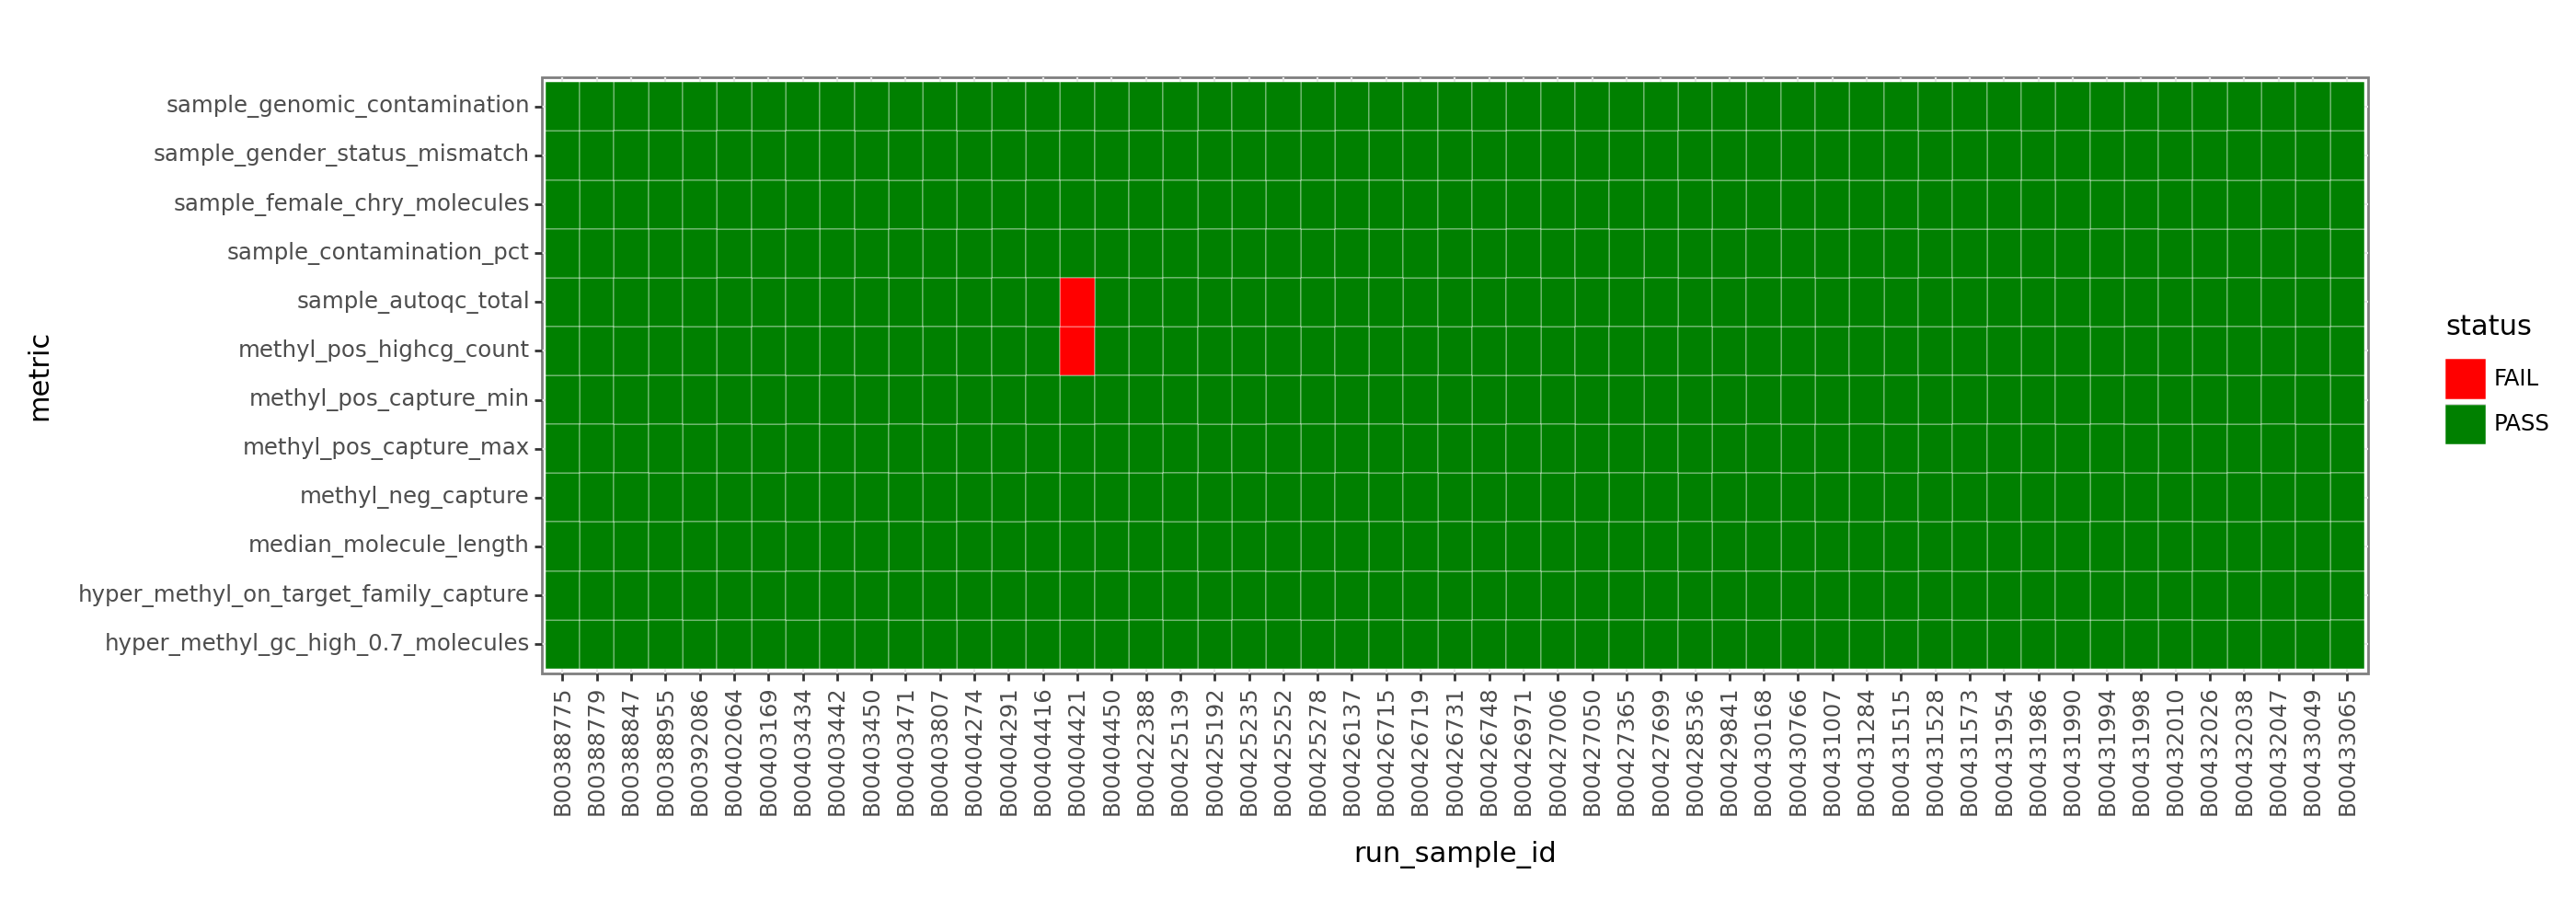

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 14 x 5 in image.
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: COS_IST04_Reveal_09_auto_qc_2025-02-07


In [96]:
plot_qc_heatmap(COS_IST04_Reveal_09_qc_df, out_prefix = "COS_IST04_Reveal_09_auto_qc_{}".format(date.today()), width=14, height=5)

In [97]:
COS_IST04_Reveal_09_qc_df.query('status == "FAIL"')

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
483,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00404421,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,12815.0,>=,13500.0,FAIL,0
751,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00404421,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,10.0,==,11.0,FAIL,0


In [98]:
samp_review_lst = COS_IST04_Reveal_09_qc_df.query('status != "PASS" & metric not in ["sample_autoqc_total", "sample_gender_status_mismatch"]')["run_sample_id"].unique()
COS_IST04_Reveal_09_qc_df.query('run_sample_id in @samp_review_lst & metric in ["sample_contamination_pct", "sample_female_chry_molecules", "sample_genomic_contamination"]').sort_values(by=["run_sample_id", "metric"])

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
437,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00404421,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00438,<=,0.5,PASS,5
952,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00404421,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0,PASS,0
523,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00404421,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,0.00000,<=,20.0,PASS,0


In [99]:
COS_IST04_Reveal_09_df.query('run_sample_id in @samp_review_lst')[["run_sample_id", "Patient_ID", "Visit_name", "methyl_score_PANCANCER", "methyl_score_BREAST", "methyl_score_CRC", "methyl_score_LUNG"]]

,run_sample_id,Patient_ID,Visit_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG
15,B00404421,COS-PC0516,Pre-NAC,-2.494598,-1.404741,-1.956923,-2.281732


### Methyl Input (Hyper-partition:methyl-subpanel)

In [101]:
methyl_input_review_df = COS_IST04_Reveal_09_df.query('flags == "Methyl Input (Hyper-partition:methyl-subpanel)"').copy()

In [102]:
methyl_input_review_df

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
15,16,NaN,B00404421,COS-PC0516,Pre-NAC,NaN,A0772469,250125_LH00520_0094_B22W57NLT3,sample_qc,Sample_level,0.000113,PANCANCER,-2.494598,-1.404741,-1.956923,-2.281732,Methyl Input (Hyper-partition:methyl-subpanel),FAIL methyl_pos_highcg_count 12815.0 >= 13500.0 molecules,NaN,FAIL: Methylation Fail,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00404421.oncotrack.pdf


In [103]:
COS_IST04_Reveal_09_df.query('Patient_ID == "COS-PC0516"')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
15,16,NaN,B00404421,COS-PC0516,Pre-NAC,NaN,A0772469,250125_LH00520_0094_B22W57NLT3,sample_qc,Sample_level,0.000113,PANCANCER,-2.494598,-1.404741,-1.956923,-2.281732,Methyl Input (Hyper-partition:methyl-subpanel),FAIL methyl_pos_highcg_count 12815.0 >= 13500.0 molecules,NaN,FAIL: Methylation Fail,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00404421.oncotrack.pdf


In [104]:
## DECISION: FAIL this sample, it's a methyaltion negative sample. No longitudinal data to compare.

## COS_IST03_Reveal_10 (GC)

In [105]:
COS_IST03_Reveal_10_df = pd.read_csv(f"{work_dir}/COS_IST03_Reveal_10_Run_23080_BART_v0 - Sheet1.csv", header = 3)
COS_IST03_Reveal_10_df.shape

(42, 22)

In [106]:
COS_IST03_Reveal_10_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,NaN,B00382614,COS-GC0219,2 Years,NaN,A0752404,250125_LH00520_0094_B22W57NLT3,NaN,NaN,0.000133,PANCANCER,-3.179677,-2.400860,-1.452567,-2.489978,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00382614.oncotrack.pdf
1,2,NaN,B00382619,COS-GC0422,1 Year and 6 Months,NaN,A0752417,250125_LH00520_0094_B22W57NLT3,NaN,NaN,0.000013,PANCANCER,-3.458060,-1.095680,-1.546735,-1.537704,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00382619.oncotrack.pdf
2,3,NaN,B00382642,COS-GC0231,2 Years,NaN,A0752441,250125_LH00520_0094_B22W57NLT3,NaN,NaN,0.000002,PANCANCER,-1.553905,-0.338955,-1.542695,-0.400564,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00382642.oncotrack.pdf
3,4,NaN,B00382665,COS-GC0159,2 Years,NaN,A0752479,250125_LH00520_0094_B22W57NLT3,NaN,NaN,0.000043,PANCANCER,-3.177846,-1.408728,-1.561825,-0.616427,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00382665.oncotrack.pdf
4,5,NaN,B00382810,COS-GC0194,2 Years,NaN,A0752565,250125_LH00520_0094_B22W57NLT3,NaN,NaN,0.000034,PANCANCER,-3.069018,-1.380929,-2.652210,-1.235733,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00382810.oncotrack.pdf


In [107]:
COS_IST03_Reveal_10_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3'],
      dtype=object)

In [108]:
COS_IST03_Reveal_10_qc_df = get_qc(COS_IST03_Reveal_10_df)

In [109]:
COS_IST03_Reveal_10_qc_df.shape

(492, 14)

In [110]:
COS_IST03_Reveal_10_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
3,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00382642,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,11.00000,==,11.0,PASS,0
5,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00408356,sample,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_on_target_family_capture,On-target family capture (Hyper-partition:methyl-subpanel),NaN,8.26000,>=,2.8,PASS,3
6,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00420645,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,10.00000,==,11.0,FAIL,0
7,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00382810,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,1.00000,<=,20.0,PASS,0
8,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00382642,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_min,Methyl Pos capture min (Hyper-partition:methyl-subpanel),NaN,1.41177,>=,1.1,PASS,5


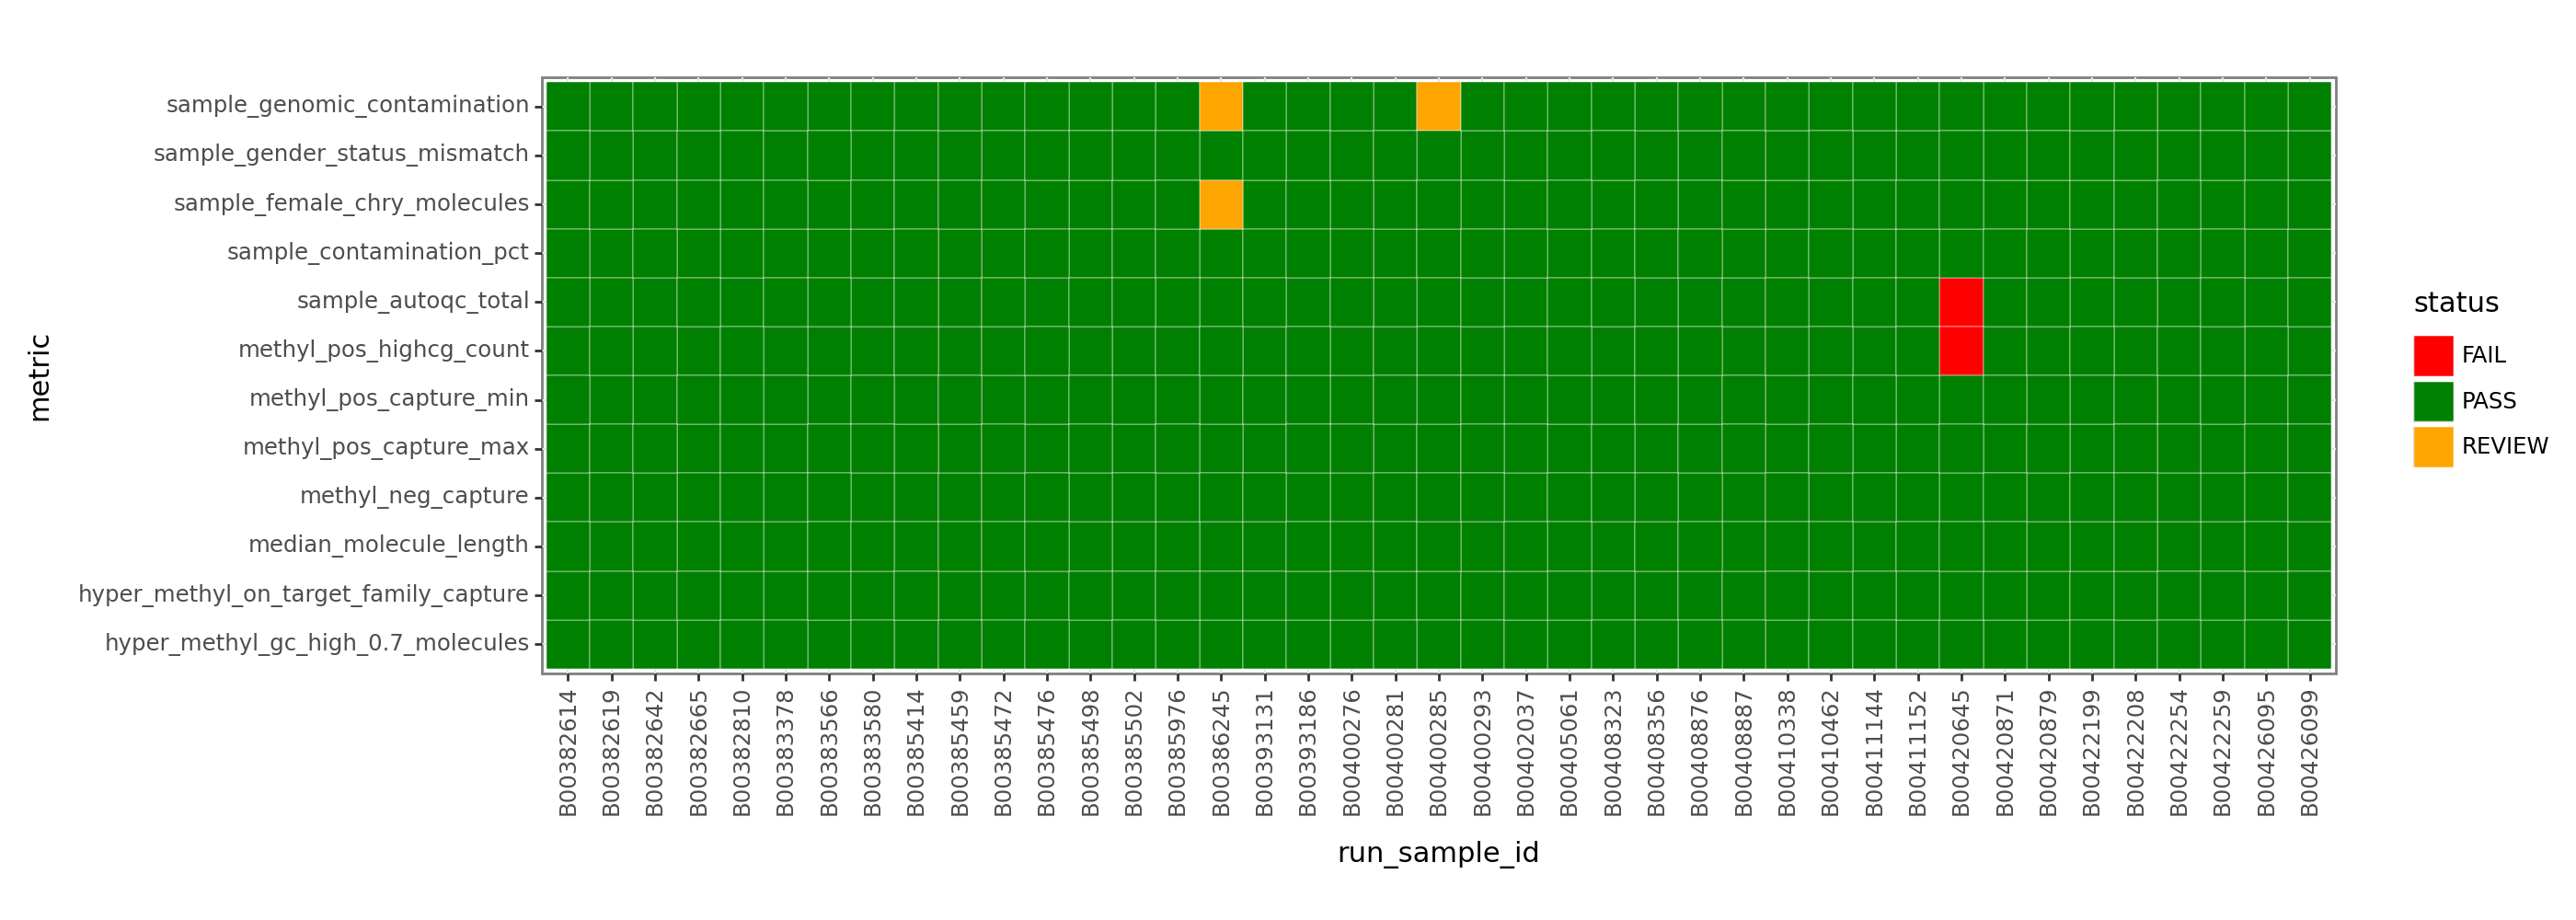

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 14 x 5 in image.
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: COS_IST03_Reveal_10_auto_qc_2025-02-07


In [111]:
plot_qc_heatmap(COS_IST03_Reveal_10_qc_df, out_prefix = "COS_IST03_Reveal_10_auto_qc_{}".format(date.today()), width=14, height=5)

In [112]:
COS_IST03_Reveal_10_qc_df.query('status == "FAIL"')

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
6,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00420645,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,10.0,==,11.0,FAIL,0
161,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00420645,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,12213.0,>=,13500.0,FAIL,0


In [113]:
samp_review_lst = COS_IST03_Reveal_10_qc_df.query('status != "PASS" & metric not in ["sample_autoqc_total", "sample_gender_status_mismatch"]')["run_sample_id"].unique()
COS_IST03_Reveal_10_qc_df.query('run_sample_id in @samp_review_lst & metric in ["sample_contamination_pct", "sample_female_chry_molecules", "sample_genomic_contamination"]').sort_values(by=["run_sample_id", "metric"])

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
366,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00386245,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00487,<=,0.5,PASS,5
1010,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00386245,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,27.00000,<=,25.0,REVIEW,0
784,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00386245,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,25.00000,<=,20.0,REVIEW,0
91,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00400285,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00524,<=,0.5,PASS,5
835,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00400285,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,24.00000,<=,25.0,PASS,0
745,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00400285,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,23.00000,<=,20.0,REVIEW,0
90,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00420645,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00509,<=,0.5,PASS,5
1039,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00420645,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0,PASS,0
752,250125_LH00520_0094_B22W57NLT3,NRE20241127R0173,B00420645,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,0.00000,<=,20.0,PASS,0


In [114]:
COS_IST03_Reveal_10_df.query('run_sample_id in @samp_review_lst')[["run_sample_id", "Patient_ID", "Visit_name", "methyl_score_PANCANCER", "methyl_score_BREAST", "methyl_score_CRC", "methyl_score_LUNG"]]

,run_sample_id,Patient_ID,Visit_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG
15,B00386245,COS-GC0565,1 Year,-3.368327,-1.192606,-2.168865,-2.181182
16,B00386245,COS-GC0565,1 Year,-3.368327,-1.192606,-2.168865,-2.181182
21,B00400285,COS-GC0217,2 Years,-3.002579,-1.540377,-1.231353,-1.712571
33,B00420645,COS-GC0288,2 Years,-3.440402,-1.443112,-1.760720,-2.894210


### contamination, positive

In [115]:
COS_IST03_Reveal_10_df["flags"].unique()

array([nan, 'Female chrY contamination', 'Genomic contamination',
       'Methyl Input (Hyper-partition:methyl-subpanel)'], dtype=object)

In [116]:
contam_review_df = COS_IST03_Reveal_10_df.query('flags in ["Genomic contamination", "Female chrY contamination"] & \
  methyl_score_PANCANCER >= 0').copy()
contam_review_df

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf


In [ ]:
# No binary caller positive contam samples. So add no warning and passed these samples.

### Methyl Input (Hyper-partition:methyl-subpanel)

In [117]:
methyl_input_review_df = COS_IST03_Reveal_10_df.query('flags == "Methyl Input (Hyper-partition:methyl-subpanel)"').copy()

In [118]:
methyl_input_review_df

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
33,34,NaN,B00420645,COS-GC0288,2 Years,NaN,A0783113,250125_LH00520_0094_B22W57NLT3,sample_qc,Sample_level,0.000235,PANCANCER,-3.440402,-1.443112,-1.76072,-2.89421,Methyl Input (Hyper-partition:methyl-subpanel),FAIL methyl_pos_highcg_count 12213.0 >= 13500.0 molecules,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00420645.oncotrack.pdf


In [119]:
COS_IST03_Reveal_10_df.query('Patient_ID == "COS-GC0288"')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
33,34,NaN,B00420645,COS-GC0288,2 Years,NaN,A0783113,250125_LH00520_0094_B22W57NLT3,sample_qc,Sample_level,0.000235,PANCANCER,-3.440402,-1.443112,-1.76072,-2.89421,Methyl Input (Hyper-partition:methyl-subpanel),FAIL methyl_pos_highcg_count 12213.0 >= 13500.0 molecules,NaN,NaN,/ghds/ivd/flowcentral/250125_LH00520_0094_B22W57NLT3,B00420645.oncotrack.pdf


In [120]:
## DECISION: FAIL this sample, it's a methyaltion negative sample. No longitudinal data to compare.

## COS_IST03_Reveal_14 (GC)

In [121]:
COS_IST03_Reveal_14_df = pd.read_csv(f"{work_dir}/COS_IST03_Reveal_14_Run_23309_BART_v0 - Sheet1.csv", header = 3)
COS_IST03_Reveal_14_df.shape

(85, 22)

In [122]:
COS_IST03_Reveal_14_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,NaN,A032799109,COS-GC0120,Pre-Surgery,NaN,A0327991,20250202_LH00666_0068_B22WGMHLT3,NaN,NaN,0.000005,PANCANCER,-1.772269,-1.114582,-1.383100,-1.522660,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/20250202_LH00666_0068_B22WGMHLT3,A032799109.oncotrack.pdf
1,2,NaN,A032825409,COS-GC0116,14 Days,NaN,A0328254,20250202_LH00666_0068_B22WGMHLT3,NaN,NaN,0.000261,PANCANCER,-2.873240,-1.155798,-2.110640,-1.105541,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/20250202_LH00666_0068_B22WGMHLT3,A032825409.oncotrack.pdf
2,3,NaN,A032825609,COS-GC0065,28 Days,NaN,A0328256,20250202_LH00666_0068_B22WGMHLT3,NaN,NaN,0.000108,PANCANCER,-1.672655,-0.854511,-0.957305,-1.797489,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/20250202_LH00666_0068_B22WGMHLT3,A032825609.oncotrack.pdf
3,4,NaN,A032836109,COS-GC0058,28 Days,NaN,A0328361,20250202_LH00666_0068_B22WGMHLT3,NaN,NaN,0.000133,PANCANCER,-3.707144,-0.833106,-1.480272,-1.775737,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/20250202_LH00666_0068_B22WGMHLT3,A032836109.oncotrack.pdf
4,5,NaN,A032912209,COS-GC0125,Pre-Surgery,NaN,A0329122,20250202_LH00666_0068_B22WGMHLT3,NaN,NaN,0.000248,PANCANCER,-3.048352,-1.107797,-2.022888,-0.773076,NaN,NaN,NaN,NaN,/ghds/ivd/flowcentral/20250202_LH00666_0068_B22WGMHLT3,A032912209.oncotrack.pdf


In [123]:
COS_IST03_Reveal_14_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/20250202_LH00666_0068_B22WGMHLT3'],
      dtype=object)

In [124]:
COS_IST03_Reveal_14_qc_df = get_qc(COS_IST03_Reveal_14_df)

In [125]:
COS_IST03_Reveal_14_qc_df.shape

(972, 14)

In [126]:
COS_IST03_Reveal_14_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
0,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035744309,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_min,Methyl Pos capture min (Hyper-partition:methyl-subpanel),NaN,1.44619,>=,1.1,PASS,5
1,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A033166509,sample,EpiReveal-1.0.0-RLS,DNA,median_molecule_length,Median Molecule Length,bases,171.00000,<=,218.0,PASS,0
2,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A033103610,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,260878.00000,>=,13500.0,PASS,0
3,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A033913109,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,11.00000,==,11.0,PASS,0
5,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035883009,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,110973.00000,>=,13500.0,PASS,0


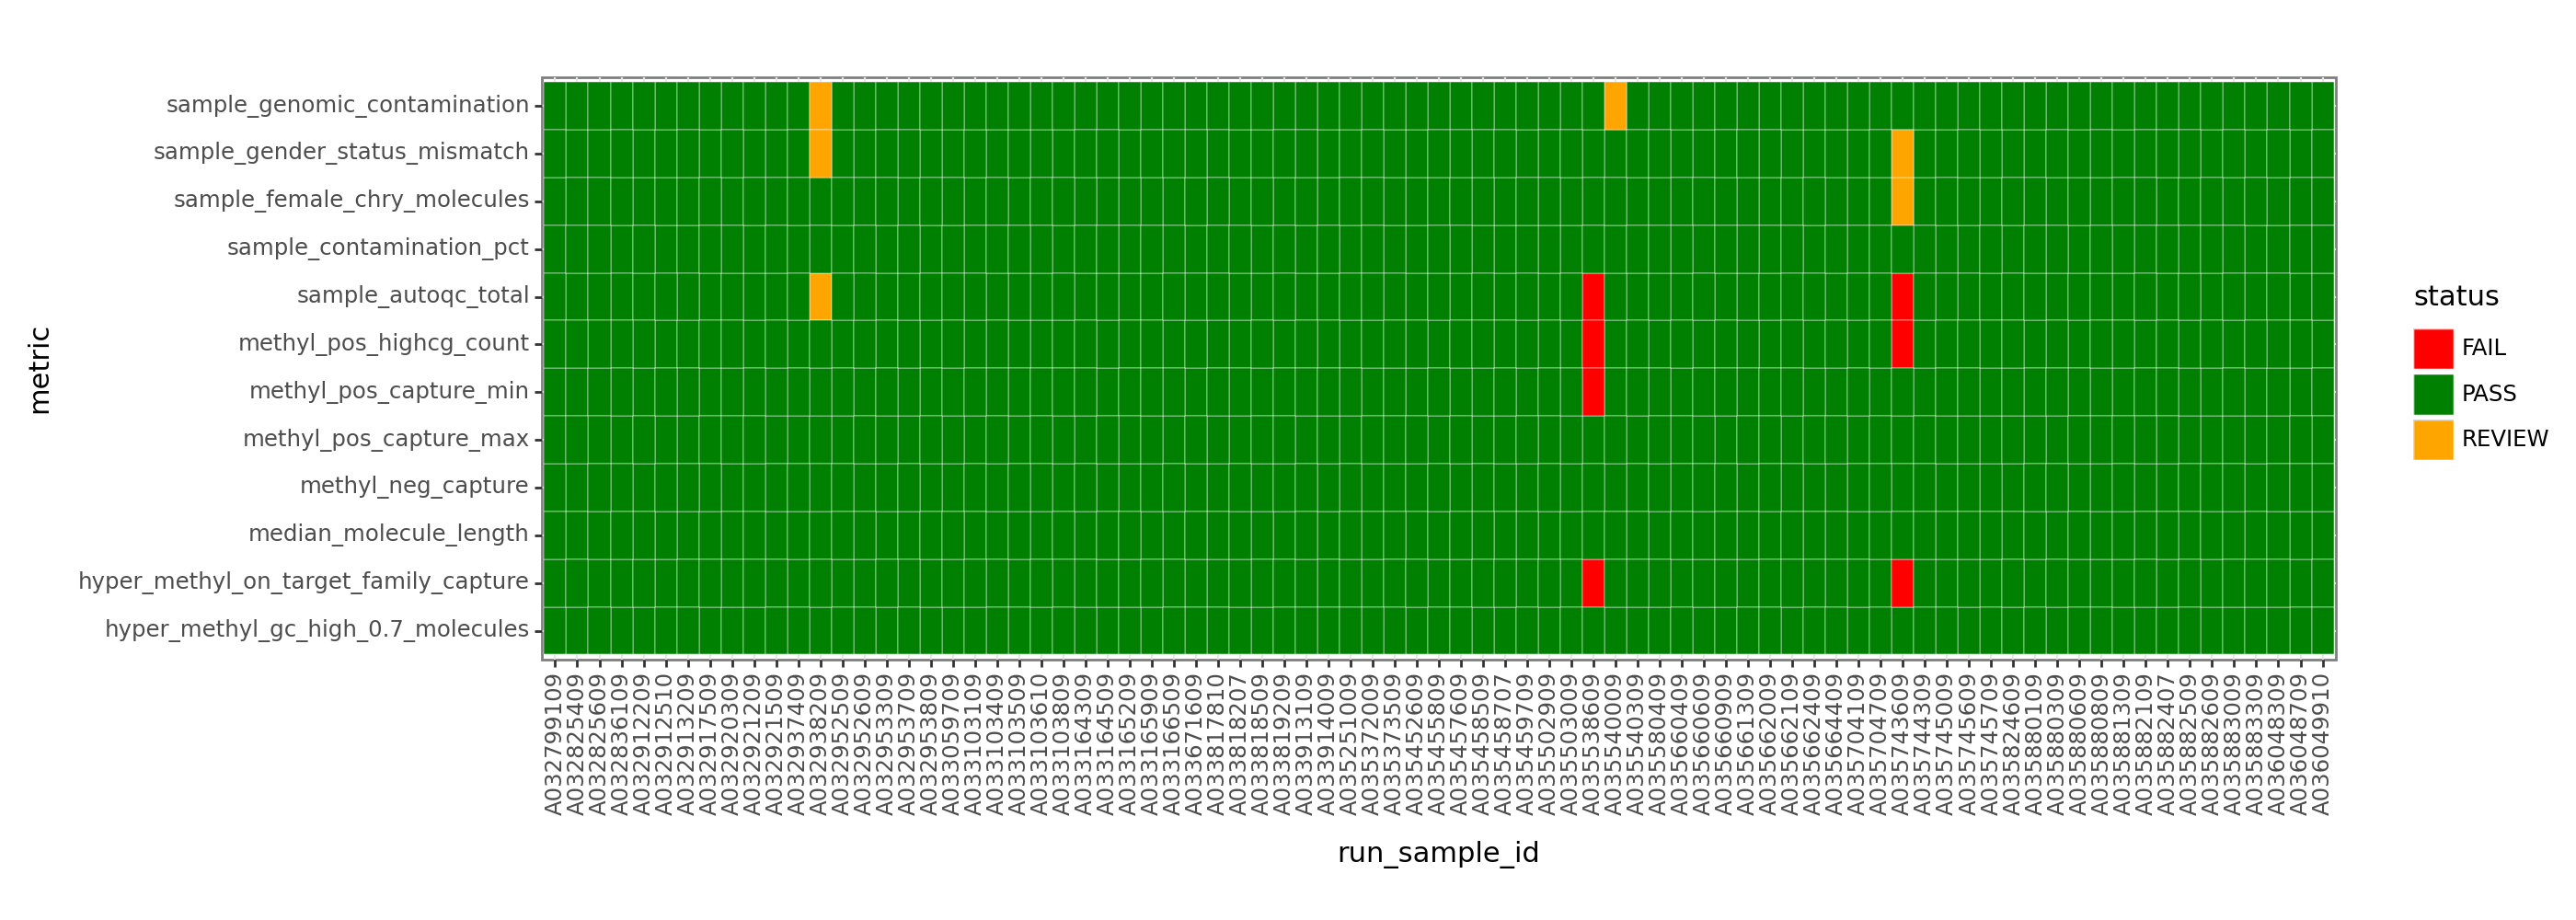

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 14 x 5 in image.
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: COS_IST03_Reveal_14_auto_qc_2025-02-07


In [127]:
plot_qc_heatmap(COS_IST03_Reveal_14_qc_df, out_prefix = "COS_IST03_Reveal_14_auto_qc_{}".format(date.today()), width=14, height=5)

In [38]:
COS_IST03_Reveal_14_qc_df.query('status == "FAIL"')

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
70,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035538609,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,8.00000,==,11.0,FAIL,0
149,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035538609,sample,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_on_target_family_capture,On-target family capture (Hyper-partition:methyl-subpanel),NaN,1.24100,>=,2.8,FAIL,3
287,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035743609,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,7.00000,==,11.0,FAIL,0
452,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035743609,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,195.00000,>=,13500.0,FAIL,0
470,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035538609,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,62.00000,>=,13500.0,FAIL,0
610,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035538609,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_min,Methyl Pos capture min (Hyper-partition:methyl-subpanel),NaN,1.08065,>=,1.1,FAIL,5
769,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035743609,sample,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_on_target_family_capture,On-target family capture (Hyper-partition:methyl-subpanel),NaN,2.14600,>=,2.8,FAIL,3


In [ ]:
# Decision: Failed A035538609 and A035743609, as low on-target rate flag was observed. 

In [133]:
samp_review_lst = COS_IST03_Reveal_14_qc_df.query('status != "PASS" & metric not in ["sample_autoqc_total", "sample_gender_status_mismatch"]')["run_sample_id"].unique()
COS_IST03_Reveal_14_qc_df.query('run_sample_id in @samp_review_lst & metric in ["sample_contamination_pct", "sample_female_chry_molecules", "sample_genomic_contamination"]').sort_values(by=["run_sample_id", "metric"])

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
398,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A032938209,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00506,<=,0.5,PASS,5
109,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A032938209,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0,PASS,0
750,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A032938209,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,181.00000,<=,20.0,REVIEW,0
955,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035538609,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00000,<=,0.5,PASS,5
713,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035538609,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0,PASS,0
609,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035538609,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,0.00000,<=,20.0,PASS,0
976,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035540009,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00565,<=,0.5,PASS,5
1006,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035540009,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0,PASS,0
488,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035540009,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,39.00000,<=,20.0,REVIEW,0
816,20250202_LH00666_0068_B22WGMHLT3,NRE20241127R0101,A035743609,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00000,<=,0.5,PASS,5


In [41]:
COS_IST03_Reveal_14_df.query('run_sample_id in @samp_review_lst')[["run_sample_id", "Patient_ID", "Visit_name", "methyl_score_PANCANCER", "methyl_score_BREAST", "methyl_score_CRC", "methyl_score_LUNG"]]

,run_sample_id,Patient_ID,Visit_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG
12,A032938209,COS-GC0060,28 Days,-1.844930,-0.918556,-1.108152,-1.865697
47,A035538609,COS-GC0014,6 Months,-2.464078,-0.268039,-1.210549,-0.649585
48,A035538609,COS-GC0014,6 Months,-2.464078,-0.268039,-1.210549,-0.649585
49,A035538609,COS-GC0014,6 Months,-2.464078,-0.268039,-1.210549,-0.649585
50,A035540009,COS-GC0221,Pre-Surgery,-1.448671,-0.958446,-1.026974,-1.100683
63,A035743609,COS-GC0189,14 Days,-2.845564,-0.262152,-1.789218,-1.538861
64,A035743609,COS-GC0189,14 Days,-2.845564,-0.262152,-1.789218,-1.538861
65,A035743609,COS-GC0189,14 Days,-2.845564,-0.262152,-1.789218,-1.538861


### contamination, positive

In [42]:
COS_IST03_Reveal_14_df["flags"].unique()

array([nan, 'Genomic contamination',
       'On-target family capture (Hyper-partition:methyl-subpanel)',
       'Methyl Input (Hyper-partition:methyl-subpanel)',
       'Methyl Pos capture min (Hyper-partition:methyl-subpanel)',
       'Female chrY contamination'], dtype=object)

In [43]:
contam_review_df = COS_IST03_Reveal_14_df.query('flags in ["Genomic contamination", "Female chrY contamination"] & \
  methyl_score_PANCANCER >= 0').copy()
contam_review_df

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf


In [ ]:
# No binary caller positive comtam samples. So passed these samples without a warning.

## (Mingyang TB) COS_IST11_Reveal_01 (MEL or CRC?)

In [ ]:
# Rachel later mentioned they were CRC, but that didn't change the methylation results

In [ ]:
# https://guardanthealth.atlassian.net/wiki/spaces/ClinicalDevelopment/pages/3544023223/NCCH+NCCHE-Namikawa+Nakamura+COS-MEL-02+COS_11

In [24]:
cos_11_01_df = read_sheet("Copy of COS_IST11_Reveal_01_Run_31919_BART_v0")
cos_11_01_df.shape

(50, 22)

In [25]:
cos_11_01_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,A025653010,,3 Months,,A0256530,20241225_LH00666_0049_A22W5TFLT3,,,0.000011,PANCANCER,-3.218477,-1.573394,-1.994744,-1.953590,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A025653010.oncotrack.pdf
1,2,,A026050510,,28 days,,A0260505,20241225_LH00666_0049_A22W5TFLT3,,,0.000205,PANCANCER,-2.652420,-0.898132,-1.448949,-1.378964,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A026050510.oncotrack.pdf
2,3,,A027257610,,28 Days,,A0272576,20241225_LH00666_0049_A22W5TFLT3,,,0.000518,PANCANCER,0.288339,1.063399,0.284550,-1.174554,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A027257610.oncotrack.pdf
3,4,,A027713510,,3 Months,,A0277135,20241225_LH00666_0049_A22W5TFLT3,,,0.002662,PANCANCER,-0.573960,0.111232,-1.120930,-0.719475,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A027713510.oncotrack.pdf
4,5,,A028370310,,6 Months,,A0283703,20241225_LH00666_0049_A22W5TFLT3,,,0.000575,PANCANCER,-2.519133,-1.024227,-1.526291,-1.565540,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A028370310.oncotrack.pdf


In [75]:
cos_11_01_df.query('methyl_score_PANCANCER >= 0 & methyl_score_CRC < 0')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf


In [76]:
cos_11_01_df.query('methyl_score_PANCANCER < 0 & methyl_score_CRC >= 0')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf


In [77]:
cos_11_01_df.query('methyl_score_PANCANCER >= 0')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
2,3,,A027257610,,28 Days,,A0272576,20241225_LH00666_0049_A22W5TFLT3,,,0.000518,PANCANCER,0.288339,1.063399,0.284550,-1.174554,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A027257610.oncotrack.pdf
20,21,,A031233810,,Recurrence,,A0312338,20241225_LH00666_0049_A22W5TFLT3,,,0.007319,PANCANCER,20.698841,8.174769,25.768071,-0.841326,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A031233810.oncotrack.pdf
24,25,,A032273010,,3 Months,,A0322730,20241225_LH00666_0049_A22W5TFLT3,,,0.000793,PANCANCER,2.857861,1.120431,8.351101,-0.652214,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A032273010.oncotrack.pdf
42,43,,A037845310,,1 year,,A0378453,20241225_LH00666_0049_A22W5TFLT3,,,0.000956,PANCANCER,5.604502,2.607879,7.529102,-1.344118,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A037845310.oncotrack.pdf
44,45,,A039958210,,6 Months,,A0399582,20241225_LH00666_0049_A22W5TFLT3,,,0.001180,PANCANCER,4.497520,1.005179,9.276474,-1.680270,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A039958210.oncotrack.pdf
45,46,,A044043610,,9 months,,A0440436,20241225_LH00666_0049_A22W5TFLT3,,,0.001614,PANCANCER,7.517691,2.073867,14.185528,-0.953145,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A044043610.oncotrack.pdf
46,47,,A045885610,,1 year and 6 months,,A0458856,20241225_LH00666_0049_A22W5TFLT3,,,0.004103,PANCANCER,12.787678,4.009814,22.555757,-2.411059,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A045885610.oncotrack.pdf
49,50,,B00162197,,1 year and 6 months,,A0541337,20241225_LH00666_0049_A22W5TFLT3,,,0.010900,PANCANCER,9.364769,4.177491,15.406279,-2.067185,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,B00162197.oncotrack.pdf


In [78]:
cos_11_01_df.query('methyl_score_CRC >= 0')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
2,3,,A027257610,,28 Days,,A0272576,20241225_LH00666_0049_A22W5TFLT3,,,0.000518,PANCANCER,0.288339,1.063399,0.284550,-1.174554,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A027257610.oncotrack.pdf
20,21,,A031233810,,Recurrence,,A0312338,20241225_LH00666_0049_A22W5TFLT3,,,0.007319,PANCANCER,20.698841,8.174769,25.768071,-0.841326,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A031233810.oncotrack.pdf
24,25,,A032273010,,3 Months,,A0322730,20241225_LH00666_0049_A22W5TFLT3,,,0.000793,PANCANCER,2.857861,1.120431,8.351101,-0.652214,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A032273010.oncotrack.pdf
42,43,,A037845310,,1 year,,A0378453,20241225_LH00666_0049_A22W5TFLT3,,,0.000956,PANCANCER,5.604502,2.607879,7.529102,-1.344118,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A037845310.oncotrack.pdf
44,45,,A039958210,,6 Months,,A0399582,20241225_LH00666_0049_A22W5TFLT3,,,0.001180,PANCANCER,4.497520,1.005179,9.276474,-1.680270,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A039958210.oncotrack.pdf
45,46,,A044043610,,9 months,,A0440436,20241225_LH00666_0049_A22W5TFLT3,,,0.001614,PANCANCER,7.517691,2.073867,14.185528,-0.953145,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A044043610.oncotrack.pdf
46,47,,A045885610,,1 year and 6 months,,A0458856,20241225_LH00666_0049_A22W5TFLT3,,,0.004103,PANCANCER,12.787678,4.009814,22.555757,-2.411059,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,A045885610.oncotrack.pdf
49,50,,B00162197,,1 year and 6 months,,A0541337,20241225_LH00666_0049_A22W5TFLT3,,,0.010900,PANCANCER,9.364769,4.177491,15.406279,-2.067185,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,B00162197.oncotrack.pdf


In [79]:
cos_11_01_df.query('methyl_score_PANCANCER >= 0')["run_sample_id"].unique().tolist() == cos_11_01_df.query('methyl_score_CRC >= 0')["run_sample_id"].unique().tolist()

True

In [26]:
cos_11_01_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3'],
      dtype=object)

In [27]:
cos_11_01_qc_df = get_qc(cos_11_01_df)

In [28]:
cos_11_01_qc_df.shape

(600, 14)

In [29]:
cos_11_01_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
0,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,A031792310,sample,EpiReveal-1.0.0-RLS,DNA,methyl_neg_capture,Methyl Neg capture (Hyper-partition:methyl-subpanel),NaN,0.00000,<=,0.0093,PASS,5
1,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,A044043610,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_max,Methyl Pos capture max (Hyper-partition:methyl-subpanel),NaN,1.46552,<=,2.0000,PASS,5
5,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,A032170310,sample,EpiReveal-1.0.0-RLS,DNA,methyl_neg_capture,Methyl Neg capture (Hyper-partition:methyl-subpanel),NaN,0.00001,<=,0.0093,PASS,5
7,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,A031233810,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_min,Methyl Pos capture min (Hyper-partition:methyl-subpanel),NaN,1.44923,>=,1.1000,PASS,5
8,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,A029611610,sample,EpiReveal-1.0.0-RLS,DNA,median_molecule_length,Median Molecule Length,bases,173.00000,<=,218.0000,PASS,0


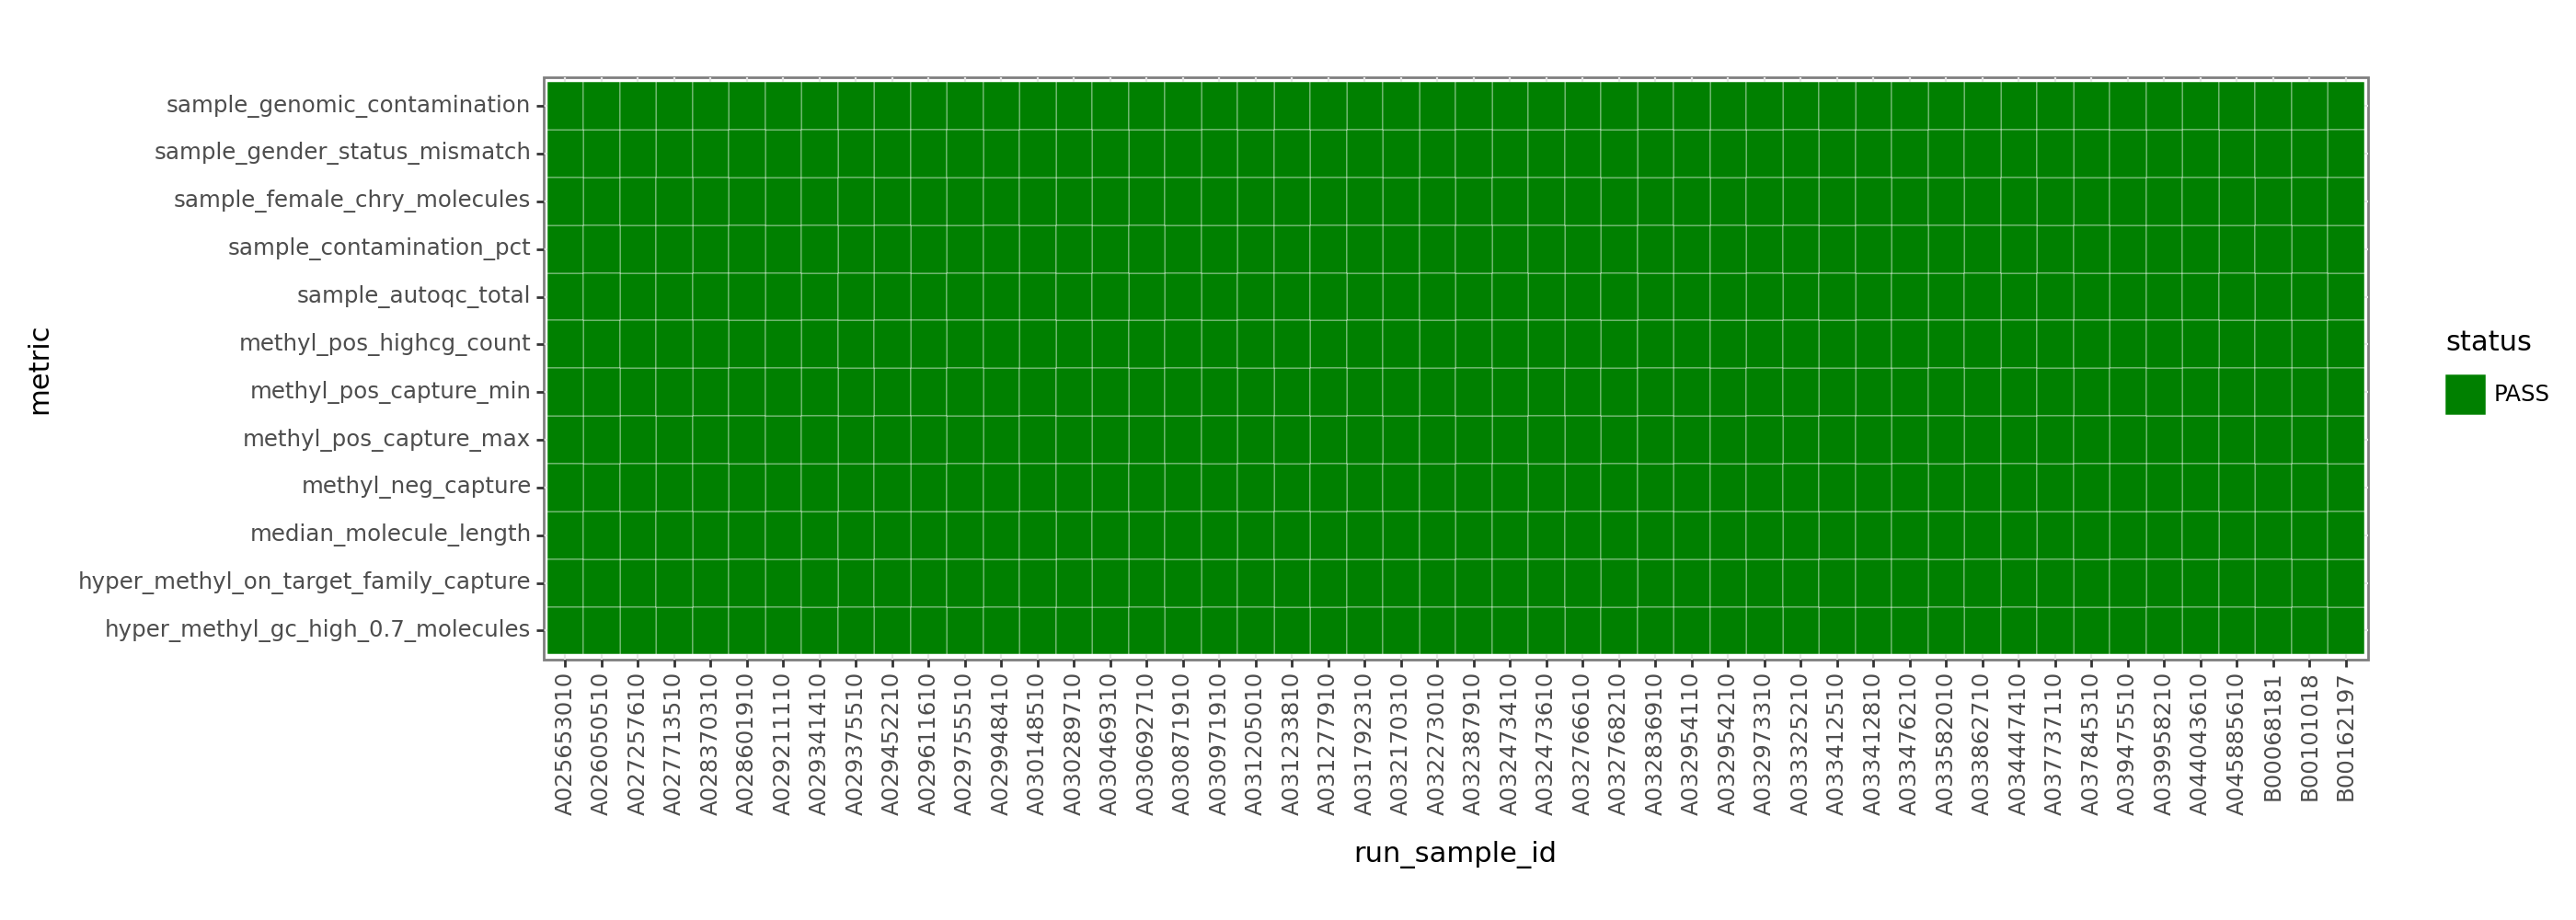

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 14 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: COS_IST11_Reveal_01_auto_qc_2025-01-14


In [30]:
plot_qc_heatmap(cos_11_01_qc_df, out_prefix = "COS_IST11_Reveal_01_auto_qc_{}".format(date.today()), width=14, height=5)

In [31]:
samp_review_lst = cos_11_01_qc_df.query('status != "PASS"')["run_sample_id"].unique()
cos_11_01_qc_df.query('run_sample_id in @samp_review_lst & metric in ["sample_contamination_pct", "sample_female_chry_molecules", "sample_genomic_contamination"]').sort_values(by=["run_sample_id", "metric"])

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places


In [32]:
cos_11_01_df.query('run_sample_id in @samp_review_lst')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf


In [33]:
cos_11_01_df.query('run_sample_id in @samp_review_lst')[["run_sample_id", "Patient_ID", "Visit_name", "methyl_score_PANCANCER", "methyl_score_BREAST", "methyl_score_CRC", "methyl_score_LUNG"]]

,run_sample_id,Patient_ID,Visit_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG


In [65]:
cos_11_01_ruo_report_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20250115_NationalCancerCenterEast_IST11_Batch1_50Samples_MonitoringReport.csv",
                                     skiprows=1)

In [66]:
calc_pos_rate(cos_11_01_ruo_report_df)

,Visit_name,Total,Positive,Positive_percentage
0,1 year,4,1.0,25.0
1,1 year and 6 months,3,2.0,66.7
2,28 Days,4,1.0,25.0
3,28 days,1,0.0,0.0
4,3 Months,18,1.0,5.6
5,6 Months,12,1.0,8.3
6,9 months,7,1.0,14.3
7,Recurrence,1,1.0,100.0
0,Total,50,8.0,16.0


In [67]:
cos_11_01_ruo_report_df.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,GH Study,NaN,A0256530,A025653010,COSMOS0015,NaN,NaN,3 Months,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,4.0,NaN,05/20/2020,05/19/2020,01/15/2025
1,GH Study,NaN,A0260505,A026050510,COSMOS0069,NaN,NaN,28 days,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,4.0,NaN,06/03/2020,05/29/2020,01/15/2025
2,GH Study,NaN,A0272576,A027257610,COSMOS0107,NaN,NaN,28 Days,SUCCESS,NaN,Detected,Detected,0.000518,NaN,4.0,NaN,07/20/2020,07/17/2020,01/15/2025
3,GH Study,NaN,A0277135,A027713510,COSMOS0087,NaN,NaN,3 Months,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,4.0,NaN,08/06/2020,08/05/2020,01/15/2025
4,GH Study,NaN,A0283703,A028370310,COSMOS0018,NaN,NaN,6 Months,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,4.0,NaN,08/31/2020,08/28/2020,01/15/2025


In [68]:
cos_11_01_ruo_report_df.query('Plasma_ml_input.isna()')

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date


In [71]:
cos_11_01_ruo_report_df["GHSampleID"].nunique()

50

In [72]:
cos_11_01_ruo_report_df["Patient_ID"].nunique()

43

## (Mingyang TB) UHP01_IST01_Reveal_01 (NSCLC)

In [ ]:
# https://guardanthealth.atlassian.net/wiki/spaces/ClinicalDevelopment/pages/3090055329/University+Hospital+of+Parma-+Tiseo+RESIDUAL+UHP_01

In [36]:
uhp01_01_01_df = read_sheet("Copy of UHP01_IST01_Reveal_01_Run_31882_BART_v0")
uhp01_01_01_df.shape

(29, 22)

In [37]:
uhp01_01_01_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,B00876796,RES-23,10 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1237284,20241225_LH00666_0049_A22W5TFLT3,,,0.000020,LUNG,-2.805319,-1.254176,-1.565027,-0.501432,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,B00876796.oncotrack.pdf
1,2,,B00876797,RES-30,20 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1237262,20241225_LH00666_0049_A22W5TFLT3,,,0.000037,LUNG,-2.299075,-1.171352,-1.659049,-0.443171,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,B00876797.oncotrack.pdf
2,3,,B00876798,RES-29,Pre-Surgery,Non-small cell lung carcinoma (NSCLC),A1237285,20241225_LH00666_0049_A22W5TFLT3,,,0.000391,LUNG,-1.940226,-0.638635,-1.465196,-0.497038,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,B00876798.oncotrack.pdf
3,4,,B00876799,RES-11,20 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1237263,20241225_LH00666_0049_A22W5TFLT3,,,0.000233,LUNG,-2.591026,-1.003632,-0.901923,-0.585091,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,B00876799.oncotrack.pdf
4,5,,B00876800,RES-29,10 days post-surgery,Non-small cell lung carcinoma (NSCLC),A1237286,20241225_LH00666_0049_A22W5TFLT3,,,0.000194,LUNG,-2.273387,-0.763888,-1.210769,-0.538638,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,B00876800.oncotrack.pdf


In [38]:
uhp01_01_01_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3'],
      dtype=object)

In [39]:
uhp01_01_01_qc_df = get_qc(uhp01_01_01_df)

In [40]:
uhp01_01_01_qc_df.shape

(348, 14)

In [41]:
uhp01_01_01_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
2,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876811,sample,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_on_target_family_capture,On-target family capture (Hyper-partition:methyl-subpanel),NaN,8.01300,>=,2.8000,PASS,3
3,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876827,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0000,PASS,0
6,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876825,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00502,<=,0.5000,PASS,5
11,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876825,sample,EpiReveal-1.0.0-RLS,DNA,methyl_neg_capture,Methyl Neg capture (Hyper-partition:methyl-subpanel),NaN,0.00002,<=,0.0093,PASS,5
13,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876810,sample,EpiReveal-1.0.0-RLS,DNA,sample_gender_status_mismatch,Gender Status Mismatch,code,2.00000,==,0.0000,REVIEW,0


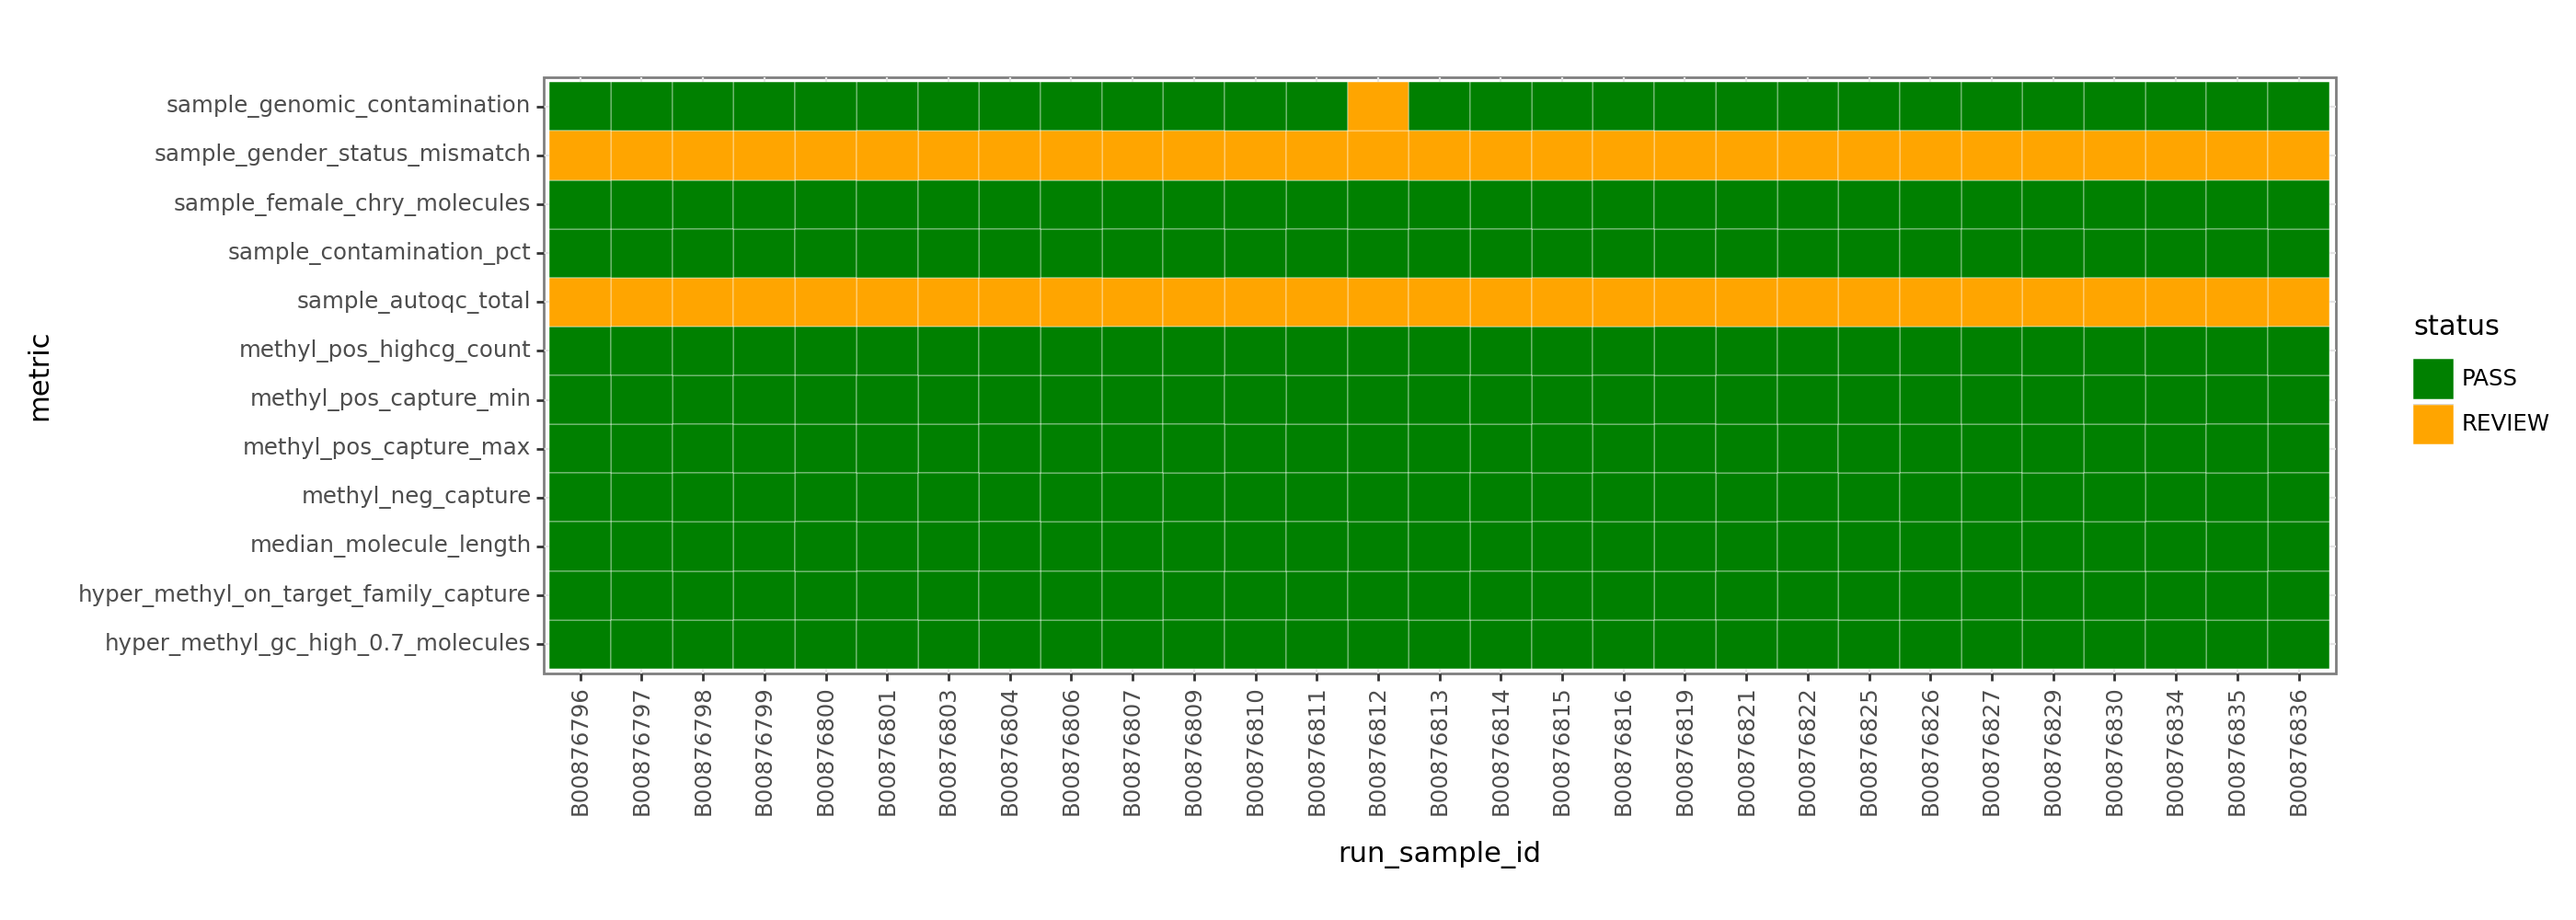

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 14 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: UHP01_IST01_Reveal_01_auto_qc_2025-01-14


In [42]:
plot_qc_heatmap(uhp01_01_01_qc_df, out_prefix = "UHP01_IST01_Reveal_01_auto_qc_{}".format(date.today()), width=14, height=5)

In [44]:
samp_review_lst = uhp01_01_01_qc_df.query('status != "PASS" & metric not in ["sample_autoqc_total", "sample_gender_status_mismatch"]')["run_sample_id"].unique()
uhp01_01_01_qc_df.query('run_sample_id in @samp_review_lst & metric in ["sample_contamination_pct", "sample_female_chry_molecules", "sample_genomic_contamination"]').sort_values(by=["run_sample_id", "metric"])

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
524,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00455,<=,0.5,PASS,5
724,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0,PASS,0
895,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,21.00000,<=,20.0,REVIEW,0


In [45]:
uhp01_01_01_qc_df.query('run_sample_id in @samp_review_lst')

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
155,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,9.00000,==,11.0000,REVIEW,0
213,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_on_target_family_capture,On-target family capture (Hyper-partition:methyl-subpanel),NaN,7.32100,>=,2.8000,PASS,3
478,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_max,Methyl Pos capture max (Hyper-partition:methyl-subpanel),NaN,1.44053,<=,2.0000,PASS,5
524,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00455,<=,0.5000,PASS,5
566,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,median_molecule_length,Median Molecule Length,bases,175.00000,<=,218.0000,PASS,0
604,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,sample_gender_status_mismatch,Gender Status Mismatch,code,2.00000,==,0.0000,REVIEW,0
652,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_min,Methyl Pos capture min (Hyper-partition:methyl-subpanel),NaN,1.44053,>=,1.1000,PASS,5
724,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0000,PASS,0
801,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,hyper_methyl_gc_high_0.7_molecules,High GC molecules 0.7 (Hyper-partition:methyl-subpanel),fraction of molecules,0.19735,>=,0.0100,PASS,5
895,20241225_LH00666_0049_A22W5TFLT3,NRE20241001R0070,B00876812,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,21.00000,<=,20.0000,REVIEW,0


In [47]:
uhp01_01_01_df.query('run_sample_id in @samp_review_lst')[["run_sample_id", "Patient_ID", "Visit_name", "methyl_score_PANCANCER", "methyl_score_BREAST", "methyl_score_CRC", "methyl_score_LUNG"]]

,run_sample_id,Patient_ID,Visit_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG
13,B00876812,RES-19,Pre-Surgery,-3.230261,-1.320015,-1.674121,-1.254513


In [48]:
uhp01_01_01_ruo_report_df = pd.read_csv("/ghsfa/projects/pharma/datawarehouse/Reveal/20250113_GuardantHealthIST_IST01_Batch1_29Samples_MonitoringReport.csv",
                                     skiprows=1)

In [49]:
calc_pos_rate(uhp01_01_01_ruo_report_df)

,Visit_name,Total,Positive,Positive_percentage
0,10 days post-surgery,11,1.0,9.1
1,20 days post-surgery,4,0.0,0.0
2,30 days post-surgery,2,0.0,0.0
3,Pre-Surgery,11,6.0,54.5
4,Trelapse,1,0.0,0.0
0,Total,29,7.0,24.1


In [51]:
uhp01_01_01_ruo_report_df[["Sample_status", "Sample_comment"]].value_counts(dropna=False)

Sample_status  Sample_comment
SUCCESS        NaN               29
dtype: int64

In [52]:
uhp01_01_01_ruo_report_df.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,RESIDUAL,RES-23 T1,A1237284,B00876796,RES-23,Non-small cell lung carcinoma (NSCLC),NaN,10 days post-surgery,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,4.0,0.0,12/05/2024,06/09/2020,01/13/2025
1,RESIDUAL,RES-30 T2,A1237262,B00876797,RES-30,Non-small cell lung carcinoma (NSCLC),NaN,20 days post-surgery,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,3.5,0.0,12/05/2024,11/16/2020,01/13/2025
2,RESIDUAL,RES-29 T0,A1237285,B00876798,RES-29,Non-small cell lung carcinoma (NSCLC),NaN,Pre-Surgery,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,3.5,1.0,12/05/2024,10/12/2020,01/13/2025
3,RESIDUAL,RES-11 T2,A1237263,B00876799,RES-11,Non-small cell lung carcinoma (NSCLC),NaN,20 days post-surgery,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,4.5,0.0,12/05/2024,02/20/2020,01/13/2025
4,RESIDUAL,RES-29 T1,A1237286,B00876800,RES-29,Non-small cell lung carcinoma (NSCLC),NaN,10 days post-surgery,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,4.5,1.0,12/05/2024,10/22/2020,01/13/2025


In [53]:
uhp01_01_01_ruo_report_df["Tumor_methylation_status"].value_counts(dropna=False)

Not Detected    22
Detected         7
Name: Tumor_methylation_status, dtype: int64

In [54]:
uhp01_01_01_ruo_report_df.query('Tumor_methylation_status == "Detected"')

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
5,RESIDUAL,RES-03 T0,A1237264,B00876801,RES-03,Non-small cell lung carcinoma (NSCLC),NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.001394,NaN,5.0,1.0,12/05/2024,12/06/2019,01/13/2025
9,RESIDUAL,RES-09 T0,A1237268,B00876807,RES-09,Non-small cell lung carcinoma (NSCLC),NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.000735,NaN,5.0,0.0,12/05/2024,01/03/2020,01/13/2025
12,RESIDUAL,RES-36 T0,A1237281,B00876811,RES-36,Non-small cell lung carcinoma (NSCLC),NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.004854,NaN,3.0,0.0,12/05/2024,11/09/2020,01/13/2025
15,RESIDUAL,RES-23 T0,A1237283,B00876814,RES-23,Non-small cell lung carcinoma (NSCLC),NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.000610,NaN,4.0,0.0,12/05/2024,05/29/2020,01/13/2025
19,RESIDUAL,RES-11 T0,A1237274,B00876821,RES-11,Non-small cell lung carcinoma (NSCLC),NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.000091,NaN,4.5,0.0,12/05/2024,01/24/2020,01/13/2025
24,RESIDUAL,RES-72 T0,A1237278,B00876829,RES-72,Non-small cell lung carcinoma (NSCLC),NaN,Pre-Surgery,SUCCESS,NaN,Detected,Detected,0.000199,NaN,2.5,1.0,05/10/2022,05/10/2022,01/13/2025
25,RESIDUAL,RES-36 T1,A1237279,B00876830,RES-36,Non-small cell lung carcinoma (NSCLC),NaN,10 days post-surgery,SUCCESS,NaN,Detected,Detected,0.001181,NaN,3.5,0.0,12/05/2024,11/26/2020,01/13/2025


In [59]:
uhp01_01_01_ruo_report_df.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,RESIDUAL,RES-23 T1,A1237284,B00876796,RES-23,Non-small cell lung carcinoma (NSCLC),NaN,10 days post-surgery,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,4.0,0.0,12/05/2024,06/09/2020,01/13/2025
1,RESIDUAL,RES-30 T2,A1237262,B00876797,RES-30,Non-small cell lung carcinoma (NSCLC),NaN,20 days post-surgery,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,3.5,0.0,12/05/2024,11/16/2020,01/13/2025
2,RESIDUAL,RES-29 T0,A1237285,B00876798,RES-29,Non-small cell lung carcinoma (NSCLC),NaN,Pre-Surgery,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,3.5,1.0,12/05/2024,10/12/2020,01/13/2025
3,RESIDUAL,RES-11 T2,A1237263,B00876799,RES-11,Non-small cell lung carcinoma (NSCLC),NaN,20 days post-surgery,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,4.5,0.0,12/05/2024,02/20/2020,01/13/2025
4,RESIDUAL,RES-29 T1,A1237286,B00876800,RES-29,Non-small cell lung carcinoma (NSCLC),NaN,10 days post-surgery,SUCCESS,NaN,Not Detected,Not Detected,0.0,NaN,4.5,1.0,12/05/2024,10/22/2020,01/13/2025


In [60]:
uhp01_01_01_ruo_report_df.query('Plasma_ml_input.isna()')

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date


In [73]:
uhp01_01_01_ruo_report_df["GHSampleID"].nunique()

29

In [74]:
uhp01_01_01_ruo_report_df["Patient_ID"].nunique()

11

## (Mingyang TB) INV01epi_IST01_Reveal_01 (Head and Neck)

In [80]:
inv01epi_01_01_df = read_sheet("Copy of INV01epi_IST01_Reveal_01_Run_31986_BART_v0")
inv01epi_01_01_df.shape

(441, 22)

In [81]:
inv01epi_01_01_df.head()

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
0,1,,B00875612,59,12 WEEKS,Head and neck squamous cell carcinoma,A1219737,241221_LH00520_0066_B22W57KLT3,,,0.000047,PANCANCER,-3.449752,-1.777792,-1.911394,-1.231019,,,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875612.oncotrack.pdf
1,2,,B00875613,133,FU 12 MONTHS,Head and neck squamous cell carcinoma,A1219539,241221_LH00520_0066_B22W57KLT3,,,0.000001,PANCANCER,-3.015017,-1.378158,-1.964284,-2.380802,,,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875613.oncotrack.pdf
2,3,,B00875614,25,BASELINE,Head and neck squamous cell carcinoma,A1219417,241221_LH00520_0066_B22W57KLT3,,,0.182863,PANCANCER,38.653853,23.145125,25.919797,18.037694,,,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875614.oncotrack.pdf
3,4,,B00875615,28,FU 24 MONTHS,Head and neck squamous cell carcinoma,A1219815,241221_LH00520_0066_B22W57KLT3,,,0.000011,PANCANCER,-2.399999,-1.557982,-1.243853,-2.539436,,,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875615.oncotrack.pdf
4,5,,B00875616,12,FU 15 MONTHS,Head and neck squamous cell carcinoma,A1219738,241221_LH00520_0066_B22W57KLT3,sample_qc,Sample_level,0.000007,PANCANCER,-2.518568,-0.929961,-2.239754,-0.526330,Genomic contamination,REVIEW sample_genomic_contamination 74.0 <= 20.0 markers,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875616.oncotrack.pdf


In [82]:
inv01epi_01_01_df["data_dir"].unique()

array(['/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3',
       '/ghds/ivd/flowcentral/20241225_LH00666_0048_B22W552LT3',
       '/ghds/ivd/flowcentral/241225_LH00505_0079_A22W57CLT3',
       '/ghds/ivd/flowcentral/20250105_LH00666_0052_A22W55TLT3',
       '/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3',
       '/ghds/ivd/flowcentral/250108_LH00520_0075_A22W55KLT3'],
      dtype=object)

In [83]:
inv01epi_01_01_qc_df = get_qc(inv01epi_01_01_df)

In [84]:
inv01epi_01_01_qc_df.shape

(5256, 14)

In [85]:
inv01epi_01_01_qc_df.head()

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
0,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875733,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,10.00000,==,11.0,REVIEW,0
1,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875632,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,10.00000,==,11.0,REVIEW,0
2,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875633,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_min,Methyl Pos capture min (Hyper-partition:methyl-subpanel),NaN,1.49625,>=,1.1,PASS,5
3,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875654,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,121565.00000,>=,13500.0,PASS,0
4,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875638,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_max,Methyl Pos capture max (Hyper-partition:methyl-subpanel),NaN,1.49574,<=,2.0,PASS,5


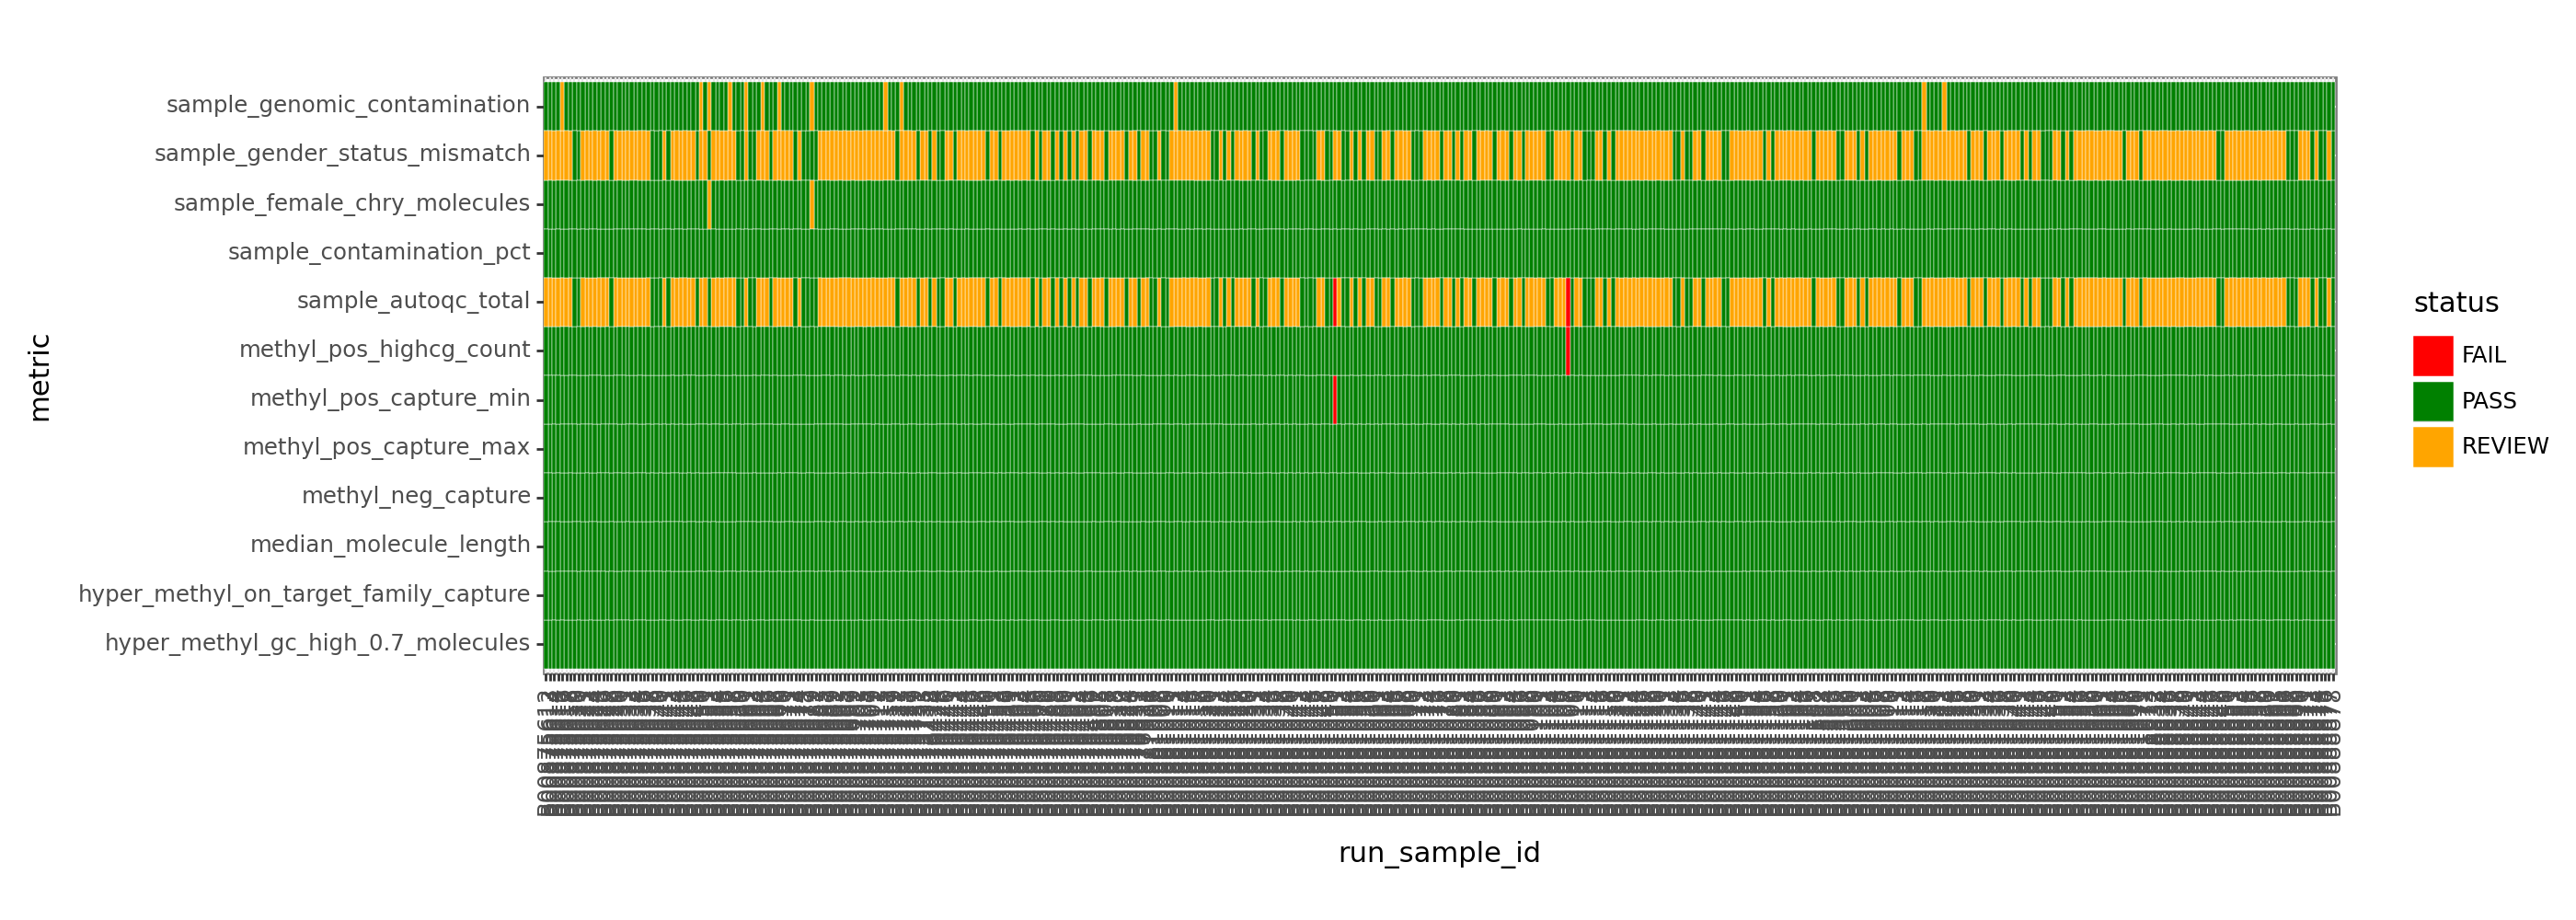

/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 14 x 5 in image.
/home/mcai/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: INV01epi_IST01_Reveal_01_auto_qc_2025-01-20


In [86]:
plot_qc_heatmap(inv01epi_01_01_qc_df, out_prefix = "INV01epi_IST01_Reveal_01_auto_qc_{}".format(date.today()), width=14, height=5)

In [174]:
inv01epi_01_01_qc_df.query('status == "FAIL"')

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
536,20241225_LH00666_0048_B22W552LT3,NRE20241001R0067,B00881108,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_highcg_count,Methyl Input (Hyper-partition:methyl-subpanel),molecules,11956.00000,>=,13500.0,FAIL,0
1103,20241225_LH00666_0048_B22W552LT3,NRE20241001R0067,B00881108,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,9.00000,==,11.0,FAIL,0
205,241225_LH00505_0079_A22W57CLT3,NRE20241001R0068,B00881051,sample,EpiReveal-1.0.0-RLS,DNA,sample_autoqc_total,Passing Sample AutoQC Tests,tests,9.00000,==,11.0,FAIL,0
766,241225_LH00505_0079_A22W57CLT3,NRE20241001R0068,B00881051,sample,EpiReveal-1.0.0-RLS,DNA,methyl_pos_capture_min,Methyl Pos capture min (Hyper-partition:methyl-subpanel),NaN,1.03576,>=,1.1,FAIL,5


In [87]:
samp_review_lst = inv01epi_01_01_qc_df.query('status != "PASS" & metric not in ["sample_autoqc_total", "sample_gender_status_mismatch"]')["run_sample_id"].unique()
inv01epi_01_01_qc_df.query('run_sample_id in @samp_review_lst & metric in ["sample_contamination_pct", "sample_female_chry_molecules", "sample_genomic_contamination"]').sort_values(by=["run_sample_id", "metric"])

,runid,sample_set,run_sample_id,category,bip_version,metric_analyte_type,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
10,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875616,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00393,<=,0.5,PASS,5
979,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875616,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0,PASS,0
664,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875616,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,74.00000,<=,20.0,REVIEW,0
556,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875650,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00540,<=,0.5,PASS,5
847,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875650,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,0.00000,<=,25.0,PASS,0
127,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875650,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,156.00000,<=,20.0,REVIEW,0
563,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875652,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00466,<=,0.5,PASS,5
944,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875652,sample,EpiReveal-1.0.0-RLS,DNA,sample_female_chry_molecules,Female chrY contamination,molecules,204.00000,<=,25.0,REVIEW,0
252,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875652,sample,EpiReveal-1.0.0-RLS,DNA,sample_genomic_contamination,Genomic contamination,markers,97.00000,<=,20.0,REVIEW,0
169,241221_LH00520_0066_B22W57KLT3,NRE20241001R0059,B00875657,sample,EpiReveal-1.0.0-RLS,DNA,sample_contamination_pct,Family contamination,%,0.00431,<=,0.5,PASS,5


In [88]:
inv01epi_01_01_df.query('run_sample_id in @samp_review_lst')[["run_sample_id", "Patient_ID", "Visit_name", "methyl_score_PANCANCER", "methyl_score_BREAST", "methyl_score_CRC", "methyl_score_LUNG"]]

,run_sample_id,Patient_ID,Visit_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG
4,B00875616,12,FU 15 MONTHS,-2.518568,-0.929961,-2.239754,-0.526330
38,B00875650,28,8 WEEKS,-2.237843,-0.808050,-1.921782,-1.657617
40,B00875652,118,8 WEEKS,-2.337557,-0.837315,-1.136401,-2.432635
41,B00875652,118,8 WEEKS,-2.337557,-0.837315,-1.136401,-2.432635
46,B00875657,30,8 WEEKS,-2.097991,-0.970673,-1.549349,-0.661821
50,B00875661,156,12 WEEKS,-1.692941,-1.094449,-2.255926,-0.642380
54,B00875665,116,FU 18 MONTHS,0.772885,-0.030823,1.005057,0.193330
58,B00875669,155,PROGRESSION,-2.345525,-0.906183,-1.946889,-1.261761
66,B00875679,111,FU 15 MONTHS,-4.242706,-1.614699,-2.623202,-2.659017
67,B00875679,111,FU 15 MONTHS,-4.242706,-1.614699,-2.623202,-2.659017


### contamination, positive

In [91]:
inv01epi_01_01_df["flags"].unique()

array(['', 'Genomic contamination', 'Female chrY contamination',
       'Methyl Pos capture min (Hyper-partition:methyl-subpanel)',
       'Methyl Input (Hyper-partition:methyl-subpanel)'], dtype=object)

In [93]:
contam_review_df = inv01epi_01_01_df.query('flags in ["Genomic contamination", "Female chrY contamination"] & \
  methyl_score_PANCANCER >= 0').copy()
contam_review_df

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
54,55,,B00875665,116,FU 18 MONTHS,Head and neck squamous cell carcinoma,A1219833,241221_LH00520_0066_B22W57KLT3,sample_qc,Sample_level,0.000174,PANCANCER,0.772885,-0.030823,1.005057,0.19333,Genomic contamination,REVIEW sample_genomic_contamination 166.0 <= 20.0 markers,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875665.oncotrack.pdf
156,157,,B00881012,154,8 WEEKS,Head and neck squamous cell carcinoma,A1219656,241225_LH00505_0079_A22W57CLT3,sample_qc,Sample_level,0.000767,PANCANCER,4.127751,2.164918,2.971299,2.78504,Genomic contamination,REVIEW sample_genomic_contamination 33.0 <= 20.0 markers,,,/ghds/ivd/flowcentral/241225_LH00505_0079_A22W57CLT3,B00881012.oncotrack.pdf


In [ ]:
# 2 samples with contam flag and positive methyl status
# check the methyl status longitudinally

In [103]:
inv01epi_01_01_df.query('Patient_ID == 116 | Patient_ID == "116"')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
54,55,,B00875665,116,FU 18 MONTHS,Head and neck squamous cell carcinoma,A1219833,241221_LH00520_0066_B22W57KLT3,sample_qc,Sample_level,1.739528e-04,PANCANCER,0.772885,-0.030823,1.005057,0.193330,Genomic contamination,REVIEW sample_genomic_contamination 166.0 <= 20.0 markers,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875665.oncotrack.pdf
57,58,,B00875668,116,FU 3 MONTHS,Head and neck squamous cell carcinoma,A1219795,241221_LH00520_0066_B22W57KLT3,,,0.000000e+00,PANCANCER,-1.939980,-1.303040,-2.035028,-0.096849,,,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875668.oncotrack.pdf
74,75,,B00875693,116,8 WEEKS,Head and neck squamous cell carcinoma,A1219391,241221_LH00520_0066_B22W57KLT3,,,3.821790e-07,PANCANCER,-2.970339,-1.234079,-2.233074,-2.118040,,,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875693.oncotrack.pdf
141,142,,B00876818,116,FU 9 MONTHS,Head and neck squamous cell carcinoma,A1219705,20241225_LH00666_0049_A22W5TFLT3,,,2.256430e-05,PANCANCER,-1.644447,-0.915352,-1.927510,-0.393889,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,B00876818.oncotrack.pdf
162,163,,B00881018,116,12 WEEKS,Head and neck squamous cell carcinoma,A1219613,241225_LH00505_0079_A22W57CLT3,,,2.726350e-06,PANCANCER,-2.468015,-1.778263,-2.918576,-1.660937,,,,,/ghds/ivd/flowcentral/241225_LH00505_0079_A22W57CLT3,B00881018.oncotrack.pdf
218,219,,B00881073,116,FU 12 MONTHS,Head and neck squamous cell carcinoma,A1219769,241225_LH00505_0079_A22W57CLT3,,,4.238261e-05,PANCANCER,-3.393048,-1.593868,-2.289399,-1.316104,,,,,/ghds/ivd/flowcentral/241225_LH00505_0079_A22W57CLT3,B00881073.oncotrack.pdf
318,319,,B00881596,116,FU 21 MONTHS,Head and neck squamous cell carcinoma,A1219618,20250105_LH00666_0052_A22W55TLT3,,,2.001789e-05,PANCANCER,-2.190952,-1.184428,-2.336912,-0.033052,,,,,/ghds/ivd/flowcentral/20250105_LH00666_0052_A22W55TLT3,B00881596.oncotrack.pdf
321,322,,B00881599,116,FU 6 MONTHS,Head and neck squamous cell carcinoma,A1219457,20250105_LH00666_0052_A22W55TLT3,,,1.528567e-06,PANCANCER,-3.304546,-1.392423,-2.069147,-0.250825,,,,,/ghds/ivd/flowcentral/20250105_LH00666_0052_A22W55TLT3,B00881599.oncotrack.pdf
323,324,,B00881601,116,FU 15 MONTHS,Head and neck squamous cell carcinoma,A1219658,20250105_LH00666_0052_A22W55TLT3,,,5.793139e-06,PANCANCER,-3.056244,-2.112773,-3.067284,-0.825869,,,,,/ghds/ivd/flowcentral/20250105_LH00666_0052_A22W55TLT3,B00881601.oncotrack.pdf
394,395,,B00881672,116,FU 24 MONTHS,Head and neck squamous cell carcinoma,A1219484,20250105_LH00666_0052_A22W55TLT3,,,1.450902e-05,PANCANCER,-2.653814,-1.645969,-1.470701,-0.596653,,,,,/ghds/ivd/flowcentral/20250105_LH00666_0052_A22W55TLT3,B00881672.oncotrack.pdf


In [106]:
inv01epi_01_01_df.query('(Patient_ID == 116 | Patient_ID == "116") & methyl_score_PANCANCER >= 0')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
54,55,,B00875665,116,FU 18 MONTHS,Head and neck squamous cell carcinoma,A1219833,241221_LH00520_0066_B22W57KLT3,sample_qc,Sample_level,0.000174,PANCANCER,0.772885,-0.030823,1.005057,0.19333,Genomic contamination,REVIEW sample_genomic_contamination 166.0 <= 20.0 markers,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875665.oncotrack.pdf


In [ ]:
# DECISION: FAIL this sample due to contamination. it's the only positive cases longitudinally, besides 116 far above 20

In [104]:
inv01epi_01_01_df.query('Patient_ID == 154 | Patient_ID == "154"')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
156,157,,B00881012,154,8 WEEKS,Head and neck squamous cell carcinoma,A1219656,241225_LH00505_0079_A22W57CLT3,sample_qc,Sample_level,0.000767,PANCANCER,4.127751,2.164918,2.971299,2.785040,Genomic contamination,REVIEW sample_genomic_contamination 33.0 <= 20.0 markers,,,/ghds/ivd/flowcentral/241225_LH00505_0079_A22W57CLT3,B00881012.oncotrack.pdf
312,313,,B00881167,154,12 WEEKS,Head and neck squamous cell carcinoma,A1219565,20241225_LH00666_0048_B22W552LT3,,,0.003187,PANCANCER,10.579151,5.521650,6.156538,7.399604,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0048_B22W552LT3,B00881167.oncotrack.pdf
335,336,,B00881613,154,FU 3 MONTHS,Head and neck squamous cell carcinoma,A1219693,20250105_LH00666_0052_A22W55TLT3,,,0.002718,PANCANCER,10.676155,5.463118,5.639022,6.864167,,,,,/ghds/ivd/flowcentral/20250105_LH00666_0052_A22W55TLT3,B00881613.oncotrack.pdf
402,403,,B00888838,154,PROGRESSION,Head and neck squamous cell carcinoma,A1219634,250108_LH00520_0075_A22W55KLT3,,,0.003274,PANCANCER,10.731289,5.911816,4.832052,7.910131,,,,,/ghds/ivd/flowcentral/250108_LH00520_0075_A22W55KLT3,B00888838.oncotrack.pdf


In [ ]:
# DECISION: keep this sample success, and add possible contam warning

### Methyl Pos capture min (Hyper-partition:methyl-subpanel)

In [101]:
methyl_pos_capture_min_review_df = inv01epi_01_01_df.query('flags == "Methyl Pos capture min (Hyper-partition:methyl-subpanel)"').copy()

In [102]:
methyl_pos_capture_min_review_df

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
196,197,,B00881051,168,FU 3 MONTHS,Head and neck squamous cell carcinoma,A1220153,241225_LH00505_0079_A22W57CLT3,sample_qc,Sample_level,0.00002,PANCANCER,-2.17042,-0.958177,-1.16431,-1.250827,Methyl Pos capture min (Hyper-partition:methyl-subpanel),FAIL methyl_pos_capture_min 1.03576 >= 1.1,,,/ghds/ivd/flowcentral/241225_LH00505_0079_A22W57CLT3,B00881051.oncotrack.pdf


In [107]:
inv01epi_01_01_df.query('Patient_ID == 168 | Patient_ID == "168"')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
15,16,,B00875627,168,8 WEEKS,Head and neck squamous cell carcinoma,A1220211,241221_LH00520_0066_B22W57KLT3,,,0.00003,PANCANCER,-2.148528,-1.175015,-1.308029,-1.781155,,,,,/ghds/ivd/flowcentral/241221_LH00520_0066_B22W57KLT3,B00875627.oncotrack.pdf
195,196,,B00881051,168,FU 3 MONTHS,Head and neck squamous cell carcinoma,A1220153,241225_LH00505_0079_A22W57CLT3,methyl_qc,Sample_level,0.00002,PANCANCER,-2.170420,-0.958177,-1.164310,-1.250827,,REVIEW hyper_methyl_pos_capture 1.03575690244003,,no change,/ghds/ivd/flowcentral/241225_LH00505_0079_A22W57CLT3,B00881051.oncotrack.pdf
196,197,,B00881051,168,FU 3 MONTHS,Head and neck squamous cell carcinoma,A1220153,241225_LH00505_0079_A22W57CLT3,sample_qc,Sample_level,0.00002,PANCANCER,-2.170420,-0.958177,-1.164310,-1.250827,Methyl Pos capture min (Hyper-partition:methyl-subpanel),FAIL methyl_pos_capture_min 1.03576 >= 1.1,,,/ghds/ivd/flowcentral/241225_LH00505_0079_A22W57CLT3,B00881051.oncotrack.pdf
420,421,,B00888856,168,12 WEEKS,Head and neck squamous cell carcinoma,A1220020,250108_LH00520_0075_A22W55KLT3,,,0.00004,PANCANCER,-2.557442,-1.096500,-1.634516,-0.991258,,,,,/ghds/ivd/flowcentral/250108_LH00520_0075_A22W55KLT3,B00888856.oncotrack.pdf


In [ ]:
## DECISION: add a "Methylation Suppression Warning" for the above sample (given all 3 time points were negative, seems okay)

### Methyl Input (Hyper-partition:methyl-subpanel)

In [108]:
methyl_input_review_df = inv01epi_01_01_df.query('flags == "Methyl Input (Hyper-partition:methyl-subpanel)"').copy()

In [109]:
methyl_input_review_df

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
253,254,,B00881108,5,FU 12 MONTHS,Larynx,A1219451,20241225_LH00666_0048_B22W552LT3,sample_qc,Sample_level,0.008202,PANCANCER,14.775964,9.309015,2.216767,14.979187,Methyl Input (Hyper-partition:methyl-subpanel),FAIL methyl_pos_highcg_count 11956.0 >= 13500.0 molecules,,,/ghds/ivd/flowcentral/20241225_LH00666_0048_B22W552LT3,B00881108.oncotrack.pdf


In [110]:
inv01epi_01_01_df.query('Patient_ID == 5 | Patient_ID == "5"')

,index,Patient,run_sample_id,Patient_ID,Visit_name,Cancertype,GHRequestID,runid,GHDB_Table,Variant_type,methyl_tf,msre_model_name,methyl_score_PANCANCER,methyl_score_BREAST,methyl_score_CRC,methyl_score_LUNG,flags,Additional_comment,Recommended_manual_change,Manual_review_change,data_dir,oncotrack_pdf
142,143,,B00876820,5,8 WEEKS,Larynx,A1219403,20241225_LH00666_0049_A22W5TFLT3,,,0.000621,PANCANCER,0.379101,0.404964,-0.639423,1.857266,,,,,/ghds/ivd/flowcentral/20241225_LH00666_0049_A22W5TFLT3,B00876820.oncotrack.pdf
253,254,,B00881108,5,FU 12 MONTHS,Larynx,A1219451,20241225_LH00666_0048_B22W552LT3,sample_qc,Sample_level,0.008202,PANCANCER,14.775964,9.309015,2.216767,14.979187,Methyl Input (Hyper-partition:methyl-subpanel),FAIL methyl_pos_highcg_count 11956.0 >= 13500.0 molecules,,,/ghds/ivd/flowcentral/20241225_LH00666_0048_B22W552LT3,B00881108.oncotrack.pdf
361,362,,B00881639,5,FU 9 MONTHS,Larynx,A1219516,20250105_LH00666_0052_A22W55TLT3,,,0.003357,PANCANCER,8.679222,5.670263,0.288826,9.233478,,,,,/ghds/ivd/flowcentral/20250105_LH00666_0052_A22W55TLT3,B00881639.oncotrack.pdf
386,387,,B00881664,5,12 WEEKS,Larynx,A1219685,20250105_LH00666_0052_A22W55TLT3,,,0.001300,PANCANCER,3.410733,2.432688,-0.788496,4.401262,,,,,/ghds/ivd/flowcentral/20250105_LH00666_0052_A22W55TLT3,B00881664.oncotrack.pdf


In [ ]:
## DECISION: PASS this sample, large methl_score, methyl count not too low, but still adding a warning message

In [113]:
ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20250115_GuardantHealth_IST01_Batch1_438Samples_MonitoringReport.csv"
inv01epi_01_01_ruo_report_df = pd.read_csv(ruo_report_csv, skiprows=1)

In [114]:
calc_pos_rate(inv01epi_01_01_ruo_report_df)

,Visit_name,Total,Positive,Positive_percentage
0,12 WEEKS,58,20,34.5
1,8 WEEKS,65,20,30.8
2,BASELINE,13,8,61.5
3,FU 12 MONTHS,37,12,32.4
4,FU 15 MONTHS,29,6,20.7
5,FU 18 MONTHS,29,6,20.7
6,FU 21 MONTHS,24,3,12.5
7,FU 24 MONTHS,20,2,10.0
8,FU 3 MONTHS,59,16,27.1
9,FU 6 MONTHS,46,9,19.6


In [111]:
inv01epi_01_01_ruo_report_df[["Sample_status", "Sample_comment"]].value_counts(dropna=False)

Sample_status  Sample_comment
SUCCESS        NaN               438
dtype: int64

### Change `Sample_status` and `Sample_comment`

In [112]:
inv01epi_01_01_ruo_report_df.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,INCLIVA,79292752,A1219737,B00875612,59,Head and neck squamous cell carcinoma,IVA,12 WEEKS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,12/17/2019,01/15/2025
1,INCLIVA,79423675,A1219539,B00875613,133,Head and neck squamous cell carcinoma,III,FU 12 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,12/09/2022,01/15/2025
2,INCLIVA,79259765,A1219417,B00875614,25,Head and neck squamous cell carcinoma,IVA,BASELINE,SUCCESS,NaN,Detected,Detected,0.182863,NaN,2.0,0.0,10/30/2024,12/04/2018,01/15/2025
3,INCLIVA,79358562,A1219815,B00875615,28,Head and neck squamous cell carcinoma,III,FU 24 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,10/26/2021,01/15/2025
4,INCLIVA,79293842,A1219738,B00875616,12,Head and neck squamous cell carcinoma,III,FU 15 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,01/31/2020,01/15/2025


In [117]:
inv01epi_01_01_ruo_report_df["Tumor_methylation_status"].value_counts(dropna=False)

Not Detected    319
Detected        119
Name: Tumor_methylation_status, dtype: int64

In [ ]:
# B00875665: FAIL, Possible Contamination
# B00881012: SUCCESS, Possible Contamination Warning
# B00881051: SUCCESS, Methylation Suppression Warning
# B00881108: SUCCESS, not to add a comment

In [115]:
with open(ruo_report_csv, "r") as file:
    # Read all lines and take the first one
    first_line = file.readline()

In [116]:
def line_prepender(filename, line):
  """ prepend a line to the beginning of a file """
  with open(filename, 'r+') as f:
    content = f.read()
    f.seek(0, 0)
    f.write(line.rstrip('\r\n') + '\n' + content)

In [175]:
new_ruo_report_df = inv01epi_01_01_ruo_report_df.copy()

new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00875665", ["Sample_status"]] = "FAIL"
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00875665", ["Sample_comment"]] = "Possible Contamination"
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00875665", ["ctDNA_detected"]] = np.nan
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00875665", ["Tumor_methylation_status"]] = np.nan
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00875665", ["Tumor_methylation_score"]] = np.nan
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00881012", ["Sample_comment"]] = "Possible Contamination Warning"
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00881051", ["Sample_comment"]] = "Methylation Suppression Warning"
new_ruo_report_df.loc[new_ruo_report_df["GHSampleID"] == "B00881108", ["Sample_comment"]] = "Methylation Suppression Warning"

new_ruo_report_csv = "/ghsfa/projects/pharma/datawarehouse/Reveal/20250120_GuardantHealth_IST01_Batch1_438Samples_MonitoringReport.csv"

new_ruo_report_df.to_csv(new_ruo_report_csv, index=False)

line_prepender(new_ruo_report_csv, first_line)

In [ ]:
# new new_ruo_report_df
# old inv01epi_01_01_ruo_report_df

In [176]:
pd.concat([new_ruo_report_df, inv01epi_01_01_ruo_report_df], axis=0).drop_duplicates(keep=False).sort_values(by=["GHSampleID"])

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
53,INCLIVA,79421852,A1219833,B00875665,116,Head and neck squamous cell carcinoma,IVA,FU 18 MONTHS,FAIL,Possible Contamination,NaN,NaN,NaN,NaN,2.0,0.0,10/30/2024,09/30/2022,01/15/2025
53,INCLIVA,79421852,A1219833,B00875665,116,Head and neck squamous cell carcinoma,IVA,FU 18 MONTHS,SUCCESS,NaN,Detected,Detected,0.000174,NaN,2.0,0.0,10/30/2024,09/30/2022,01/15/2025
154,INCLIVA,79424375,A1219656,B00881012,154,Head and neck squamous cell carcinoma,IVB,8 WEEKS,SUCCESS,Possible Contamination Warning,Detected,Detected,0.000767,NaN,2.0,0.0,10/30/2024,01/20/2023,01/15/2025
154,INCLIVA,79424375,A1219656,B00881012,154,Head and neck squamous cell carcinoma,IVB,8 WEEKS,SUCCESS,NaN,Detected,Detected,0.000767,NaN,2.0,0.0,10/30/2024,01/20/2023,01/15/2025
193,INV_01,79496848,A1220153,B00881051,168,Head and neck squamous cell carcinoma,III,FU 3 MONTHS,SUCCESS,Methylation Suppression Warning,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,10/20/2023,01/15/2025
193,INV_01,79496848,A1220153,B00881051,168,Head and neck squamous cell carcinoma,III,FU 3 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,10/20/2023,01/15/2025
250,INCLIVA,BB7926,A1219451,B00881108,5,Larynx,IVA,FU 12 MONTHS,SUCCESS,Methylation Suppression Warning,Detected,Detected,0.008202,NaN,1.5,0.0,10/30/2024,11/20/2018,01/15/2025
250,INCLIVA,BB7926,A1219451,B00881108,5,Larynx,IVA,FU 12 MONTHS,SUCCESS,NaN,Detected,Detected,0.008202,NaN,1.5,0.0,10/30/2024,11/20/2018,01/15/2025


In [177]:
new_ruo_report_df.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,INCLIVA,79292752,A1219737,B00875612,59,Head and neck squamous cell carcinoma,IVA,12 WEEKS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,12/17/2019,01/15/2025
1,INCLIVA,79423675,A1219539,B00875613,133,Head and neck squamous cell carcinoma,III,FU 12 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,12/09/2022,01/15/2025
2,INCLIVA,79259765,A1219417,B00875614,25,Head and neck squamous cell carcinoma,IVA,BASELINE,SUCCESS,NaN,Detected,Detected,0.182863,NaN,2.0,0.0,10/30/2024,12/04/2018,01/15/2025
3,INCLIVA,79358562,A1219815,B00875615,28,Head and neck squamous cell carcinoma,III,FU 24 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,10/26/2021,01/15/2025
4,INCLIVA,79293842,A1219738,B00875616,12,Head and neck squamous cell carcinoma,III,FU 15 MONTHS,SUCCESS,NaN,Not Detected,Not Detected,0.000000,NaN,2.0,0.0,10/30/2024,01/31/2020,01/15/2025


In [178]:
new_ruo_report_df.query('Plasma_ml_input.isna()')

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date


In [130]:
new_ruo_report_df["GHSampleID"].nunique()

438

In [132]:
new_ruo_report_df["Patient_ID"].nunique()

74

In [133]:
new_ruo_report_df.query('Sample_status == "SUCCESS"')["GHSampleID"].nunique()

437

In [134]:
437/438

0.997716894977169

In [136]:
new_ruo_report_df.query('Sample_status == "SUCCESS" & ctDNA_detected == "Detected"')["GHSampleID"].nunique()

118

In [137]:
118 + 319

437

In [138]:
118/437

0.2700228832951945

In [139]:
calc_pos_rate(new_ruo_report_df)

,Visit_name,Total,Positive,Positive_percentage
0,12 WEEKS,58,20,34.5
1,8 WEEKS,65,20,30.8
2,BASELINE,13,8,61.5
3,FU 12 MONTHS,37,12,32.4
4,FU 15 MONTHS,29,6,20.7
5,FU 18 MONTHS,28,5,17.9
6,FU 21 MONTHS,24,3,12.5
7,FU 24 MONTHS,20,2,10.0
8,FU 3 MONTHS,59,16,27.1
9,FU 6 MONTHS,46,9,19.6
